In [74]:
%matplotlib notebook

import pickle

from tqdm import tqdm
import numpy as np
import torch
from torcheval.metrics.functional import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy
from torch.utils.data import TensorDataset, DataLoader

from sklearn import datasets, manifold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

In [75]:
def data_range_shape(data: np.ndarray):
    print(data.shape)
    print(data)
    print(f"Value Range: [{np.min(data)}:{np.max(data)}]")
    
def label_range_shape(label: np.ndarray):
    print(label.shape)
    print(label)
    uniques, counts = np.unique(label, return_counts=True)
    total = sum(counts)
    lab = []
    nums = []
    ratios = []
    infos = []
    for unique, count in zip(uniques, counts):
        lab.append(unique)
        nums.append(count)
        ratios.append(count / total)
        infos.append(f"{count} ({str(round(count / total * 100, 2))}%)")
    print(f"Class Num: {np.unique(label)}, {dict(zip(uniques, infos))}")
    
def data_amplify(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, amplify: None):
    duplication = 1
    uniques = np.unique(y_train)
    if amplify is None:
        duplication = [1] * uniques
    elif isinstance(amplify, int):
        duplication = [amplify] * uniques
    elif isinstance(amplify, list):
        if len(amplify) == 1:
            duplication = [amplify] * uniques
        elif len(amplify) != uniques:
            raise ValueError(f'the length of amplify list should be the same as the number of unique values')
        else:
            duplication = amplify
    else:
        raise TypeError(f'amplify should be None, int, or list, not {type(amplify)}')
    
def cofusion_matrix(clf, X_test: np.array, y_test: np.array):
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            display_labels=[0, 1, 2],
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    
def plot_importance(importances: np.array, clf=None):
    if clf != None:
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    forest_importances = pd.Series(importances)

    fig, ax = plt.subplots()
    if clf != None:
        forest_importances.plot.bar(yerr=std, ax=ax)
    else:
        forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    
def correlation_map(data):
    d = pd.DataFrame(data=data, columns=list(range(data.shape[1])))

    # Compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(12, 12),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

def evaluate_model(clf, eval_data: np.array, eval_labels: np.array, train_data: np.array, train_labels: np.array):
    # Testing Dataset
    eval_pred_label = clf.predict(eval_data)
    eval_acc: float = accuracy_score(eval_labels, eval_pred_label)
    eval_f1: float = f1_score(eval_labels, eval_pred_label, average='weighted')
    eval_precision: float = precision_score(train_labels, train_pred_label, average='weighted')
    eval_recall: float = recall_score(train_labels, train_pred_label, average='weighted')
    print(f"Test Acc: {eval_acc}, Test F1: {eval_f1}, Test Precision: {eval_precision}, Test Recall: {eval_recall}")
    cofusion_matrix(clf, eval_data, eval_labels)

    # Training Dataset
    train_pred_label = clf.predict(train_data)
    train_acc: float = accuracy_score(train_labels, train_pred_label)
    train_f1: float = f1_score(train_labels, train_pred_label, average='weighted')
    train_precision: float = precision_score(train_labels, train_pred_label, average='weighted')
    train_recall: float = recall_score(train_labels, train_pred_label, average='weighted')
    print(f"Train Acc: {train_acc}, Train F1: {train_f1}, Train Precision: {train_precision}, Train Recall: {train_recall}")
    cofusion_matrix(clf, train_data, train_labels)
    return eval_acc, eval_f1, train_acc, train_f1

def xgb_gridsearch(params: dict, file_name: str, X_train: np.array, y_train: np.array):
    gsearch = GridSearchCV(estimator = XGBClassifier(n_estimators=100, objective='multi:softmax', seed=27), 
     param_grid=params, scoring='f1_weighted', n_jobs=-1, cv=5)
    gsearch.fit(X_train, y_train)

    with open(f'{file_name}.pkl', 'wb') as f:
        pickle.dump(gsearch, f, pickle.HIGHEST_PROTOCOL)
    with open(f'{file_name}.pkl', 'rb') as f:
        grid_search = pickle.load(f)
    print(f"{file_name} | Best Param: {grid_search.best_params_}")
    print(f"{file_name} | Best Score: {grid_search.best_score_}")
    return grid_search

def pca_trans(n_components: int, X_train: np.array, X_test: np.array):
    pca = PCA(n_components=n_components).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    data_range_shape(X_train_pca)
    return X_train_pca, X_test_pca

def iso_trans(X_train: np.array, y_train: np.array):
    iso = IsolationForest(n_estimators=100, random_state=0, n_jobs=-1, warm_start=True).fit(X_train)
    outliner_idxs = iso.predict(X_train)
    X_train_iso = X_train[outliner_idxs == 1]
    y_train_iso = y_train[outliner_idxs == 1]

    data_range_shape(X_train_iso)
    data_range_shape(y_train_iso)
    return X_train_iso, y_train_iso

# Load Dataset

In [64]:
train_data = np.load('Test/train_data.npy')
data_range_shape(data=train_data)

train_labels = np.load('Test/train_labels.npy')
label_range_shape(label=train_labels)

(1174461, 70)
[[ 0.85 -0.71  0.14 ...  0.35  0.39  0.06]
 [ 1.13 -0.03  0.14 ...  0.35  0.39  0.06]
 [ 0.76 -0.03  0.14 ...  0.35  0.39  0.06]
 ...
 [ 0.33 -0.79 -0.24 ...  0.24  0.36  0.03]
 [ 0.33  1.54 -0.24 ...  0.24  0.36  0.03]
 [-0.69  0.02 -0.05 ...  0.24  0.36  0.03]]
Value Range: [-23.281249999999996:3399900.0]
(1174461,)
[1 1 0 ... 1 1 0]
Class Num: [0 1 2], {0: '637044 (54.24%)', 1: '256946 (21.88%)', 2: '280471 (23.88%)'}


In [65]:
eval_data = np.load('Test/eval_data.npy')
data_range_shape(data=eval_data)

eval_labels = np.load('Test/eval_labels.npy')
label_range_shape(label=eval_labels)

(1175302, 70)
[[-0.16  1.73  0.14 ...  0.26  0.32  0.03]
 [-0.06  1.52  0.14 ...  0.26  0.32  0.03]
 [-0.16  1.52  0.14 ...  0.26  0.32  0.03]
 ...
 [-1.08  0.03  0.13 ...  0.24  0.36  0.02]
 [-0.45  0.03  0.13 ...  0.24  0.36  0.02]
 [-1.56  0.23  0.13 ...  0.24  0.36  0.02]]
Value Range: [-208.31396230799652:205000.0]
(1175302,)
[1 1 1 ... 2 2 0]
Class Num: [0 1 2], {0: '635393 (54.06%)', 1: '249039 (21.19%)', 2: '290870 (24.75%)'}


# Scale with Standard Scaler

In [66]:
sc = StandardScaler().fit(train_data)
train_data_sc = sc.transform(train_data)
eval_data_sc = sc.transform(eval_data)
data_range_shape(train_data_sc)

(1174461, 70)
[[ 0.85 -0.71  0.14 ...  0.59  0.37  0.39]
 [ 1.13 -0.03  0.14 ...  0.59  0.37  0.39]
 [ 0.76 -0.03  0.14 ...  0.59  0.37  0.39]
 ...
 [ 0.33 -0.79 -0.24 ... -0.21 -0.18 -0.26]
 [ 0.33  1.54 -0.24 ... -0.21 -0.18 -0.26]
 [-0.69  0.02 -0.05 ... -0.21 -0.18 -0.26]]
Value Range: [-60.85795064477092:791.5795519580987]


# Check with XGBoost

In [30]:
xgboostModel = XGBClassifier(n_estimators=100, max_depth=20)
xgboostModel.fit(train_data_sc, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Importance Analysis
As we can see, most of feautures are useless. Thus, I decide to compress the dimensions of the dataset with PCA.


<IPython.core.display.Javascript object>


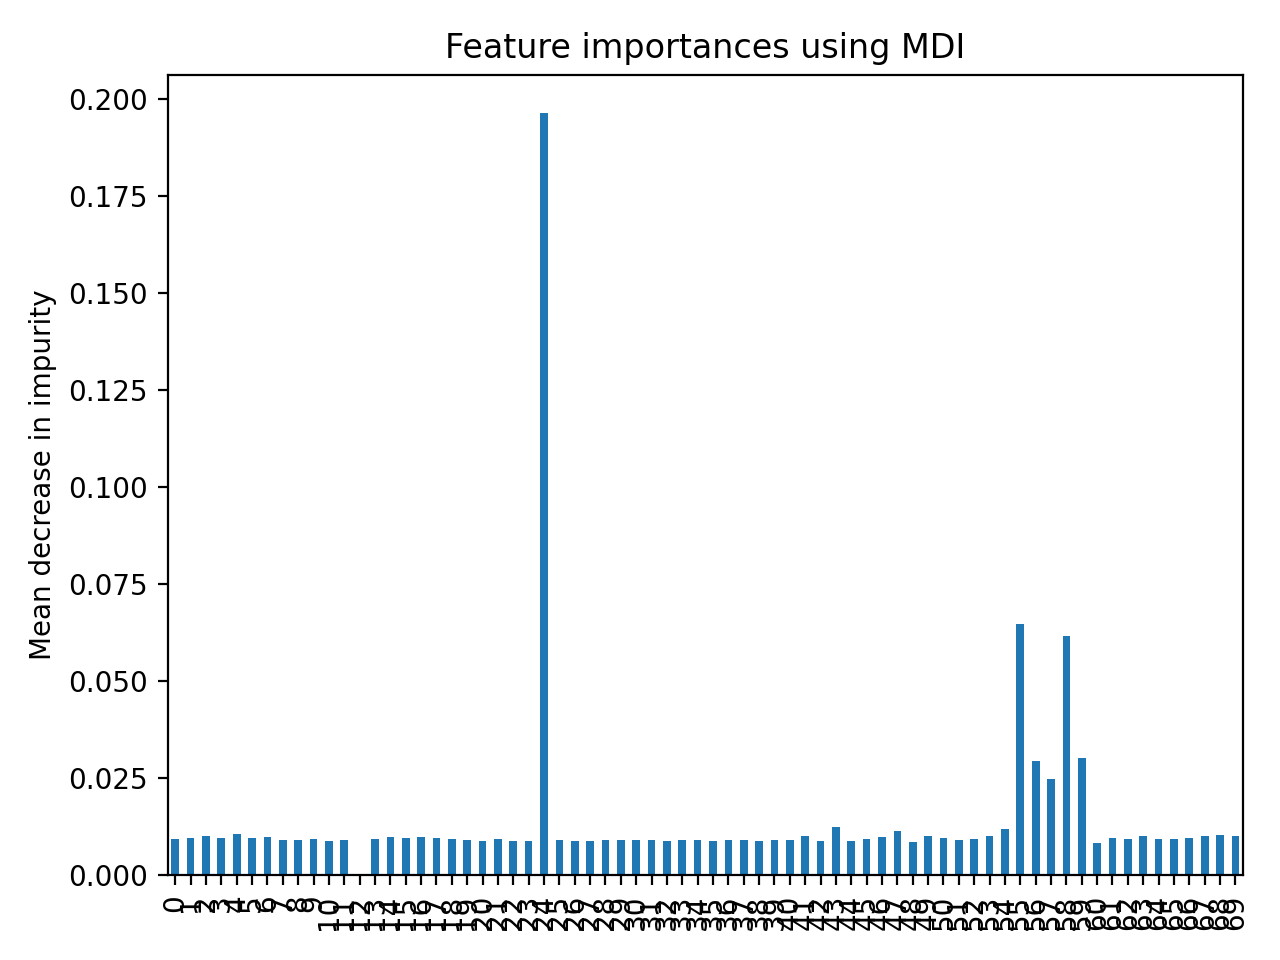

In [31]:
importances = xgboostModel.feature_importances_
plot_importance(importances=importances)

## Overfitting
Because the testing accuracy and F1-Score are much lower than the training accuracy and F1-Score, we focus on how to eliminate the overfitting. In the mean time, the confusion matrix shows that the classifier is hard to classify the samples of the class 1 and 2 correctly.

### Potential Reasons
##### (1) Ditribution Shift: DIfferent distrbution between training and testing datasets
##### (2) Noisy data: Too many outliners or useless features
##### (3) Overly Complex Model: The model is too complex.

### Solutions
##### (1) Ditribution Shift: Combine training and testing dataset and re-sample training and testing sets
##### (2) Noisy data: Filter outliners & Dataset compression
##### (3) Overly Complex Model: Hyperparameter tuning with grid search and regularization

Test Acc: 0.5836984877078402, Test F1: 0.5760067962875496


<IPython.core.display.Javascript object>


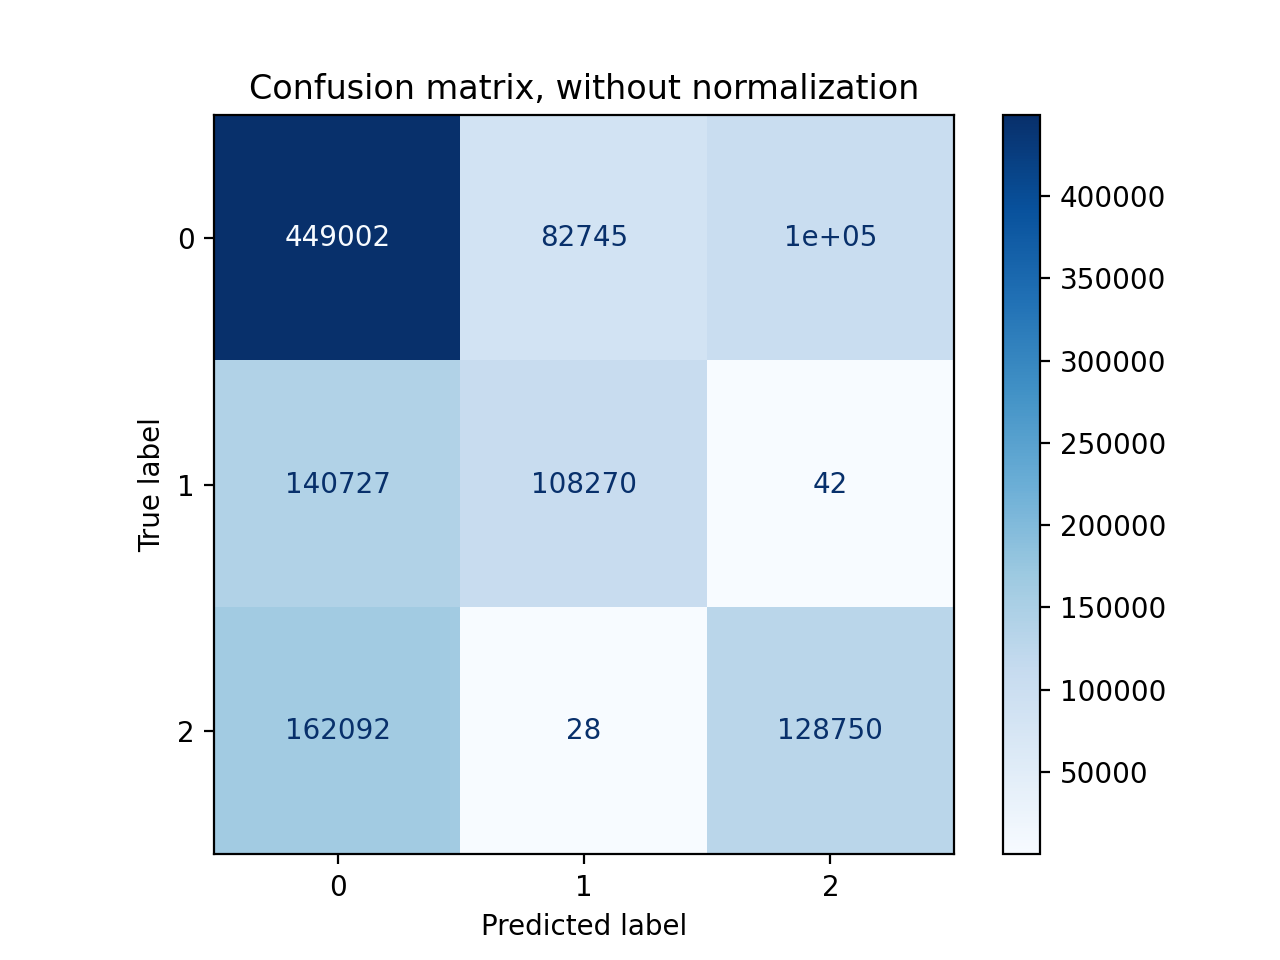

Confusion matrix, without normalization
[[449002  82745 103646]
 [140727 108270     42]
 [162092     28 128750]]


<IPython.core.display.Javascript object>


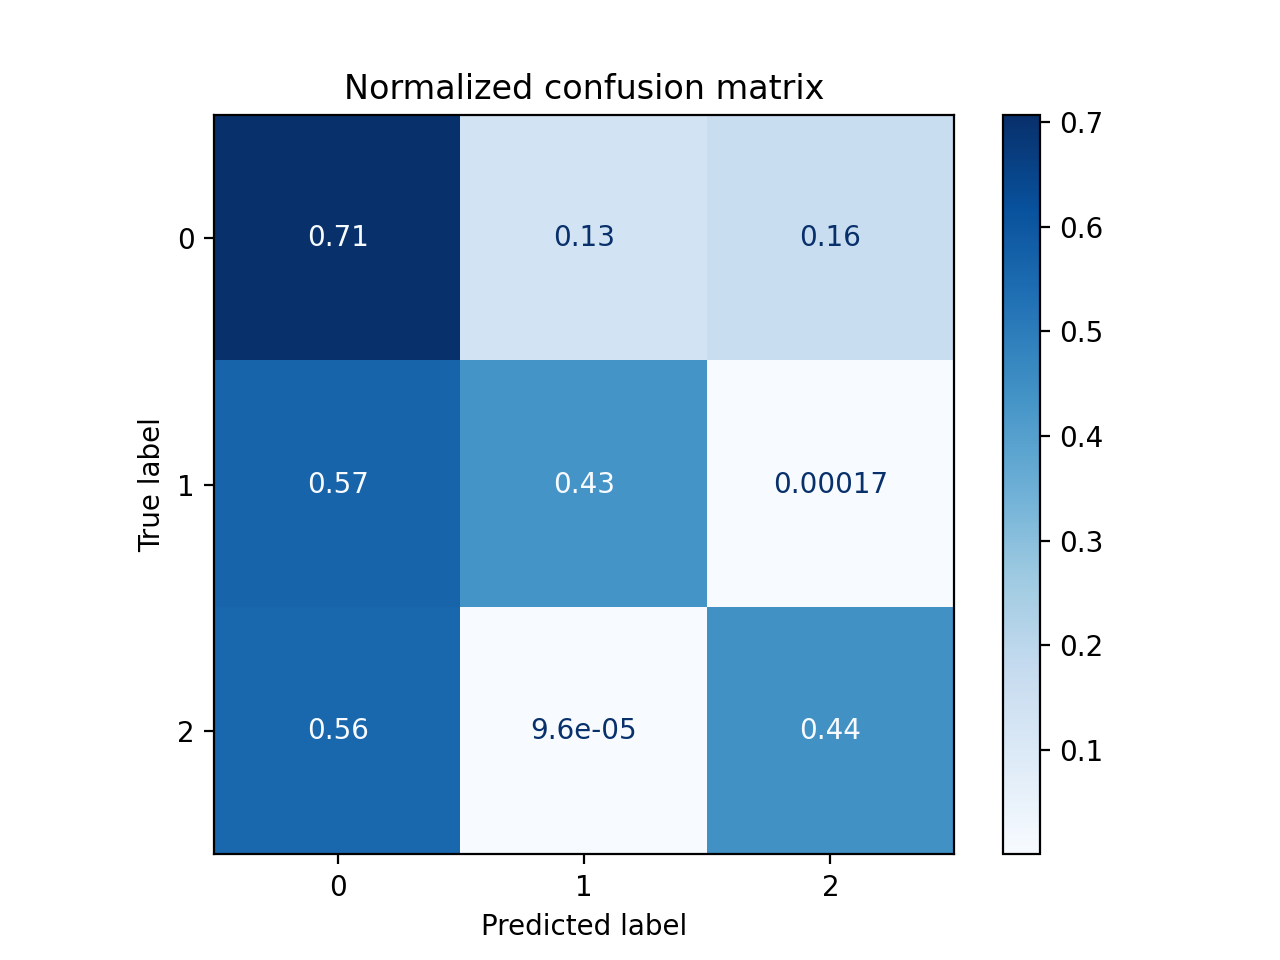

Normalized confusion matrix
[[7.07e-01 1.30e-01 1.63e-01]
 [5.65e-01 4.35e-01 1.69e-04]
 [5.57e-01 9.63e-05 4.43e-01]]
Train Acc: 1.0, Train F1: 1.0


<IPython.core.display.Javascript object>


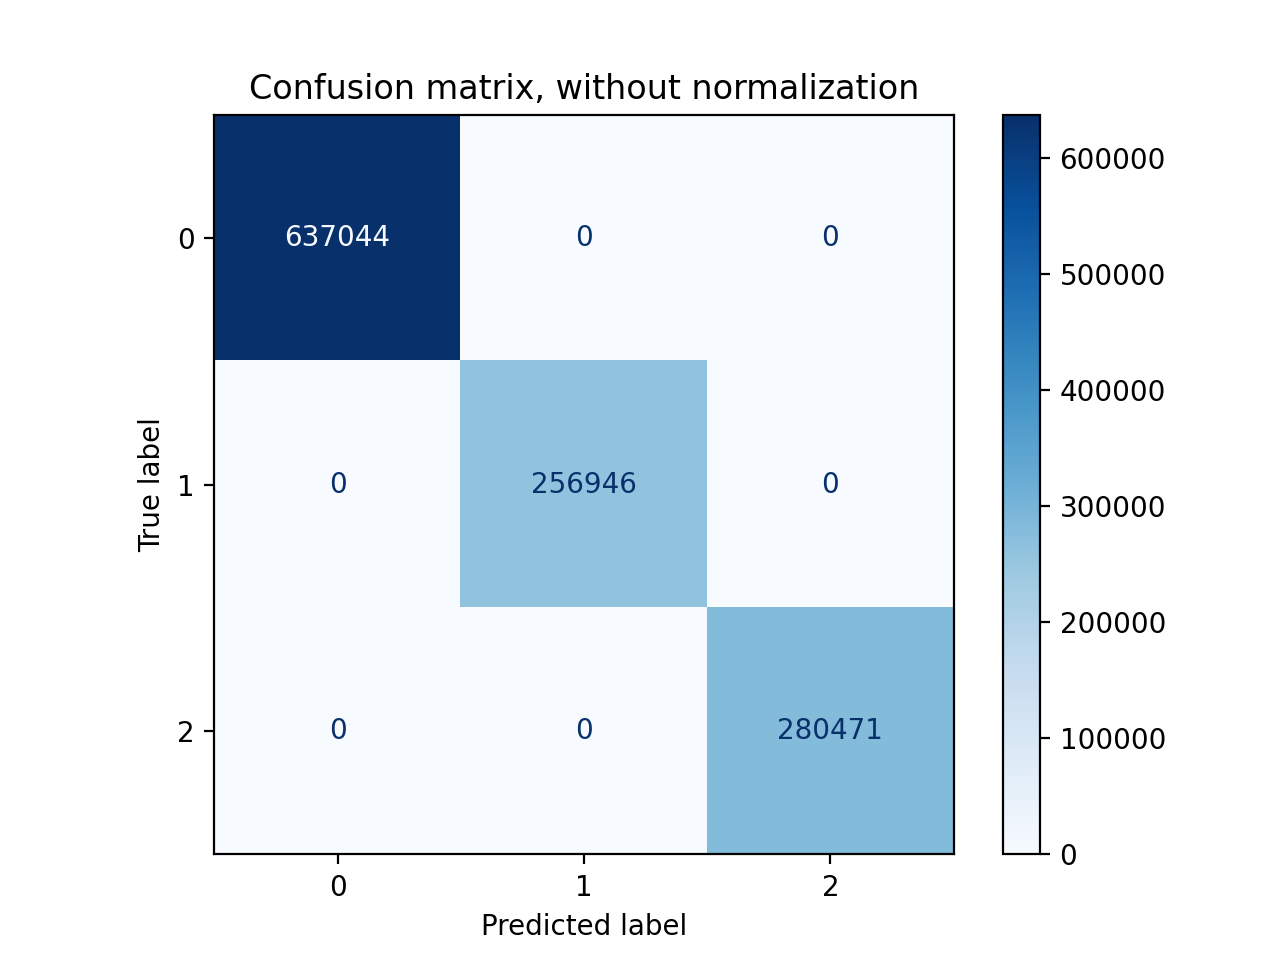

Confusion matrix, without normalization
[[637044      0      0]
 [     0 256946      0]
 [     0      0 280471]]


<IPython.core.display.Javascript object>


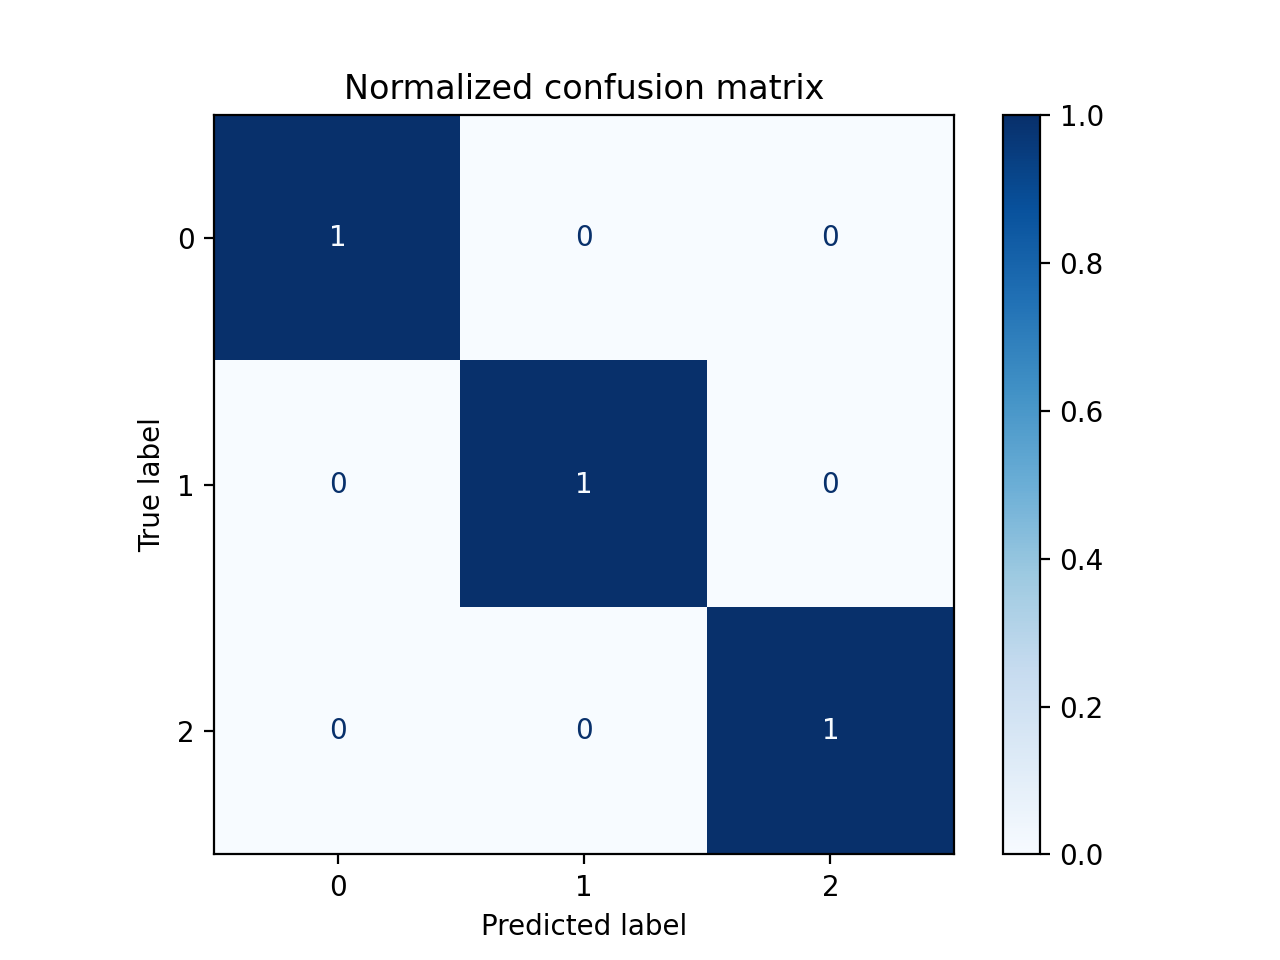

Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [32]:
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=xgboostModel, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=train_data_sc, train_labels=train_labels)

# Poential Reason 1: Distribution Shift
Here I combine the training and evaluating dataset and re-sample a new training and evaluating dataset. If the ditribution shift exists, the overfitting issue should disappear.

In [ ]:
data_sc: np.array = np.concatenate((train_data_sc, eval_data_sc), axis=0)
labels: np.array = np.concatenate((train_labels, eval_labels), axis=None)
X_test, X_train, y_test, y_train = train_test_split(data_sc, labels, test_size=0.5, random_state=42, shuffle=True)

However, the overfitting still exists. Thus, the distrbution shift should not be the main cause.

In [ ]:
xgboostModel = XGBClassifier(n_estimators=100, max_depth=20)
xgboostModel.fit(X_train, y_train)
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=xgboostModel, eval_data=X_test, eval_labels=y_test, train_data=X_train, train_labels=y_train)

# Potential Reason 2: Noisy data

I come up with 2 solution, PCA decomposition and outliner filter.

## (1) PCA Decomposition
## Search for Best Component Number for PCA Decomposition
The results is shown as below cells. In conclusion, I found no-compression yields the best accuracy and F1 score in testing dataset, which are 59.8% and 58.8%. Therefore, I will keep all features for the next stage.
### No Compression

In [43]:
param_pca = {
 'max_depth': [5, 10, 15, 20],
}

xgb_gridsearch(params=param_pca, file_name='gsearch_pca70', X_train=train_data_sc, y_train=train_labels)

gsearch_pca70 | Best Param: {'max_depth': 5}
gsearch_pca70 | Best Score: 0.5413649555424597


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1, param_grid={'max_depth': [5, 10, 15, 20]},
             scoring='f1_weighted')

gsearch_pca70 | Best Param: {'max_depth': 5}
gsearch_pca70 | Best Score: 0.5413649555424597
Test Acc: 0.5982130550275588, Test F1: 0.5886126018809283


<IPython.core.display.Javascript object>


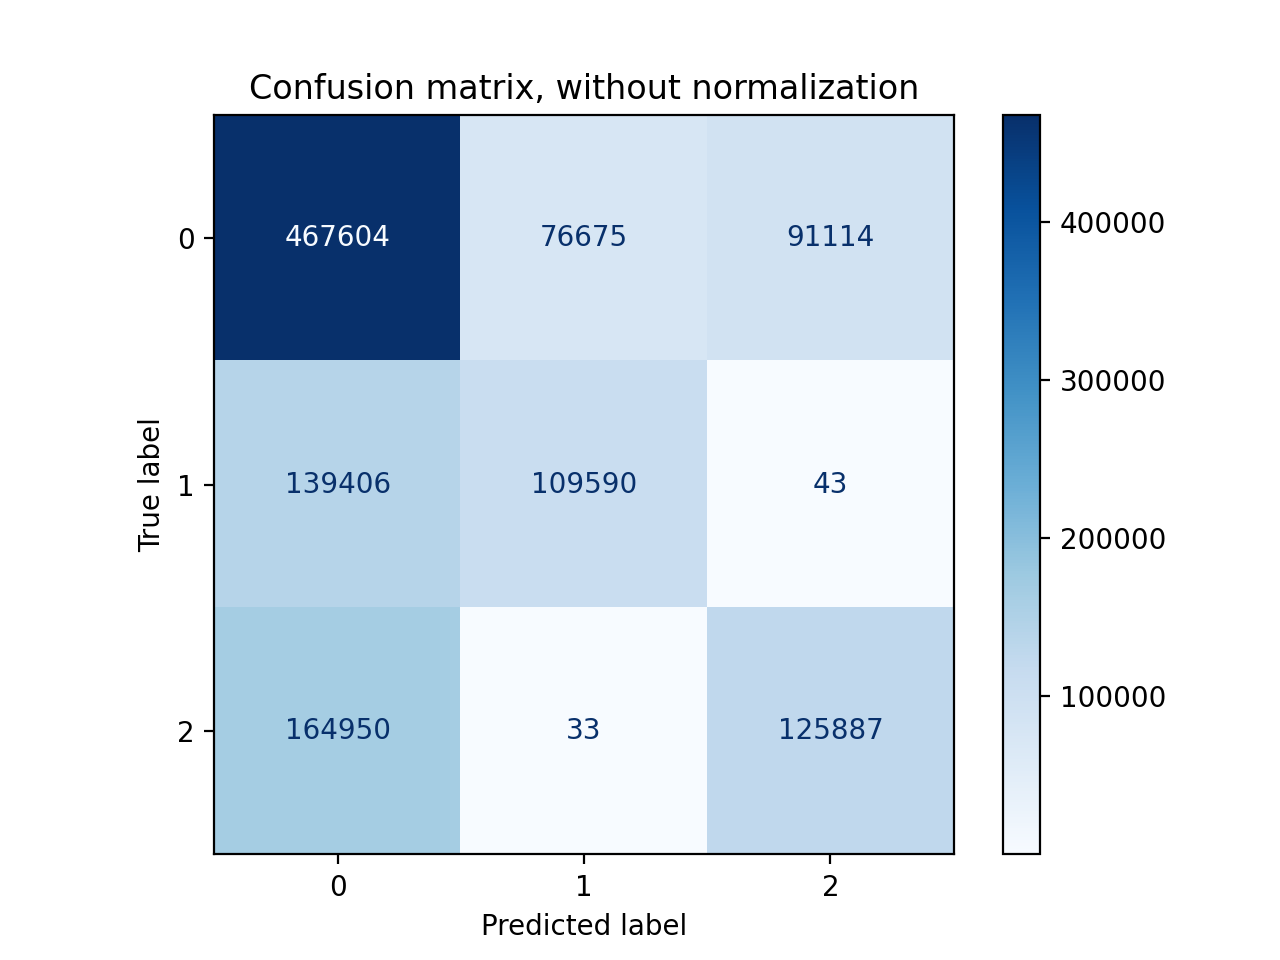

Confusion matrix, without normalization
[[467604  76675  91114]
 [139406 109590     43]
 [164950     33 125887]]


<IPython.core.display.Javascript object>


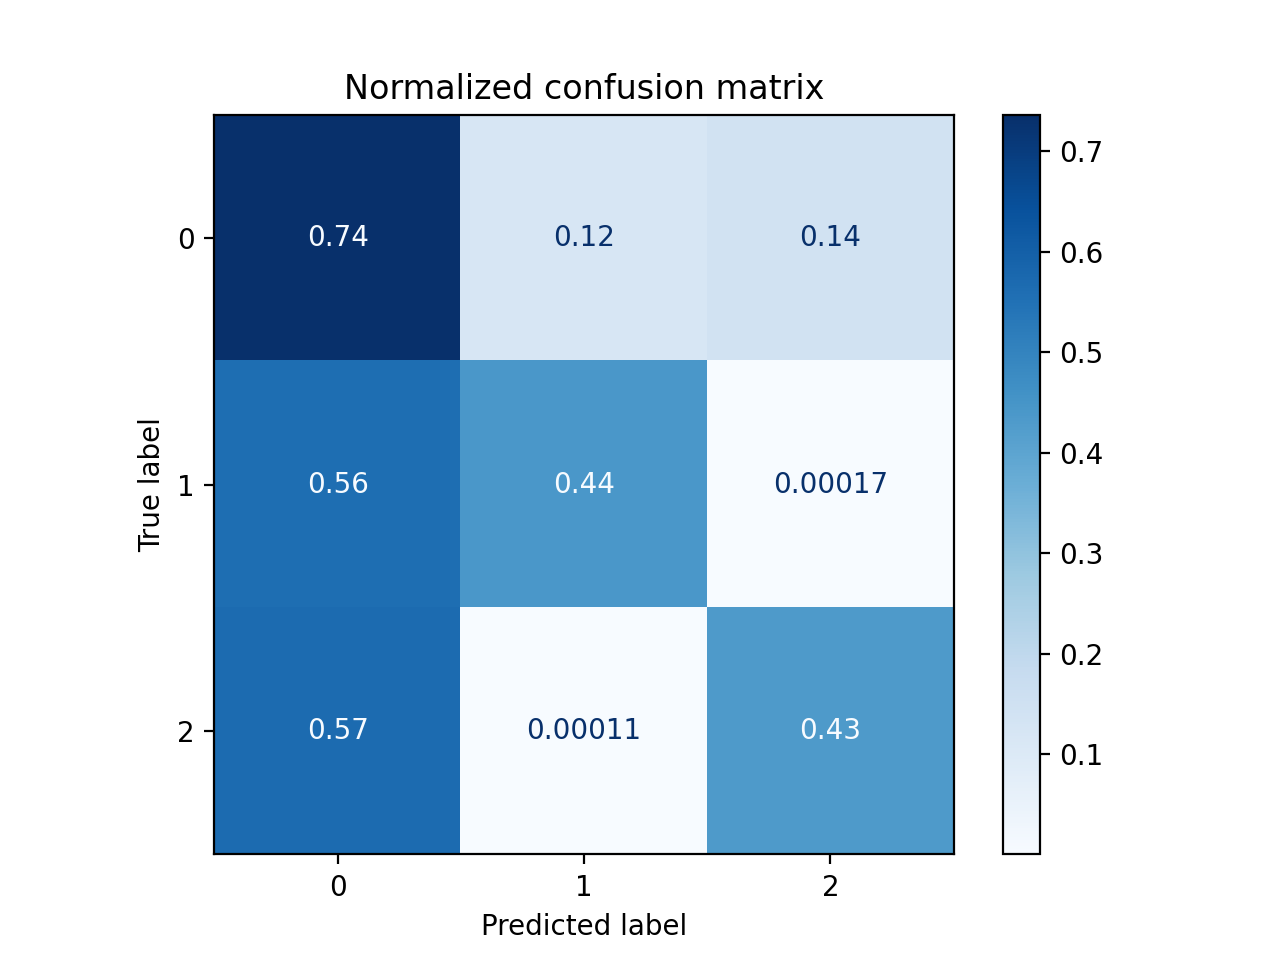

Normalized confusion matrix
[[7.36e-01 1.21e-01 1.43e-01]
 [5.60e-01 4.40e-01 1.73e-04]
 [5.67e-01 1.13e-04 4.33e-01]]
Train Acc: 0.6307361419408563, Train F1: 0.6262574487302827


<IPython.core.display.Javascript object>


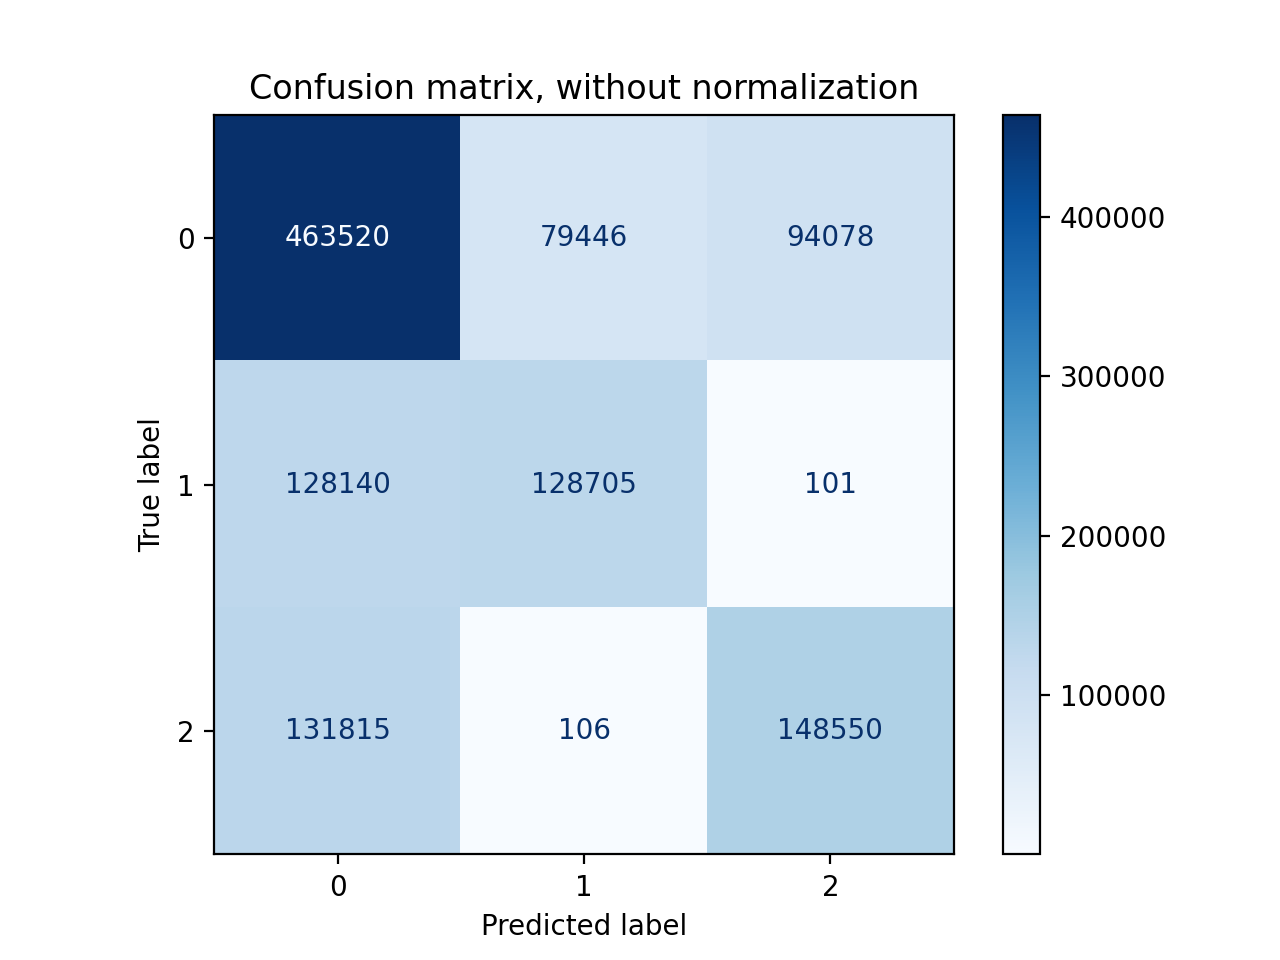

Confusion matrix, without normalization
[[463520  79446  94078]
 [128140 128705    101]
 [131815    106 148550]]


<IPython.core.display.Javascript object>


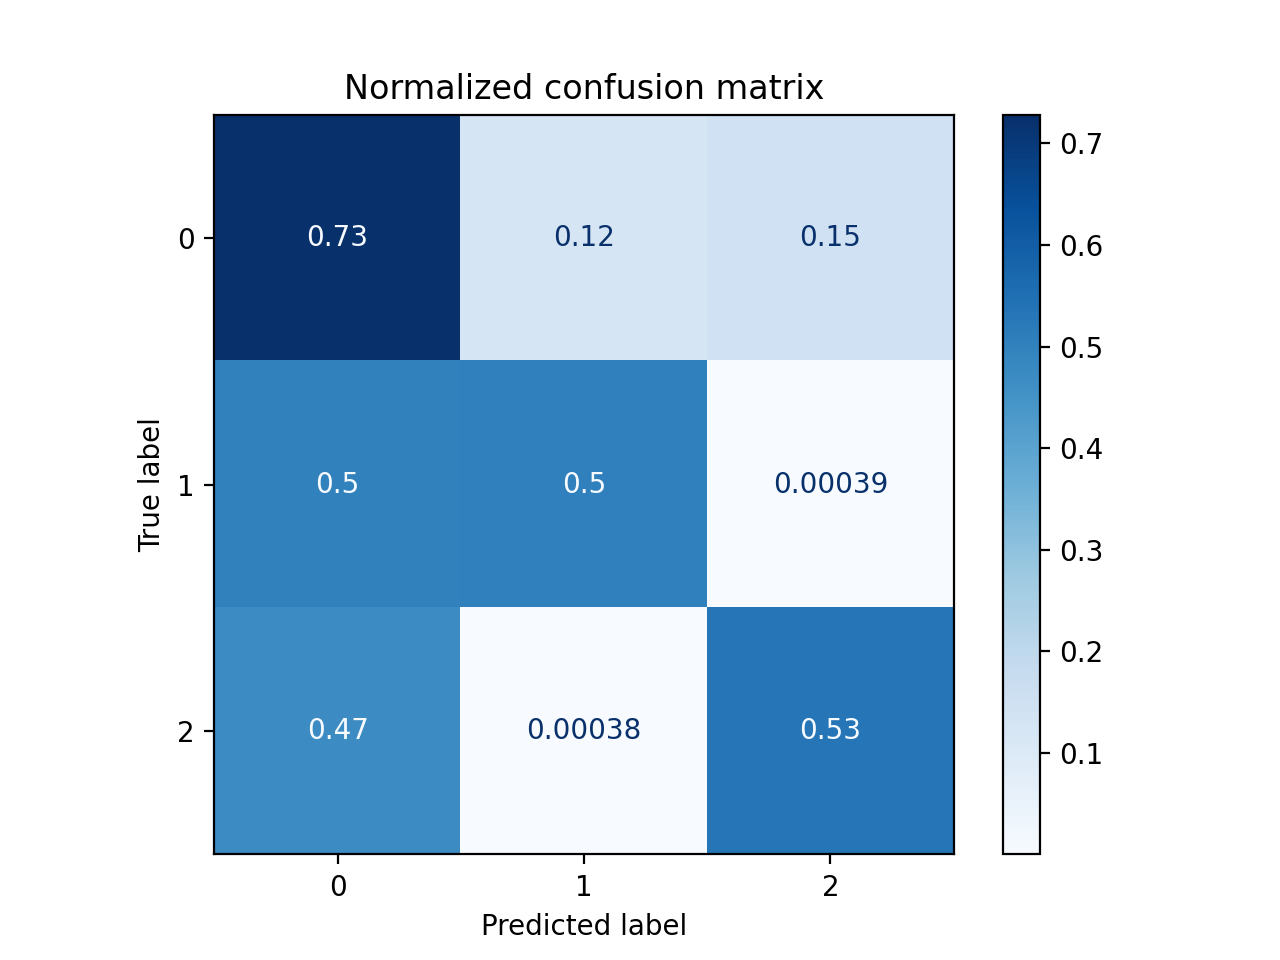

Normalized confusion matrix
[[7.28e-01 1.25e-01 1.48e-01]
 [4.99e-01 5.01e-01 3.93e-04]
 [4.70e-01 3.78e-04 5.30e-01]]


In [50]:
file_name='gsearch_pca70'
with open(f'{file_name}.pkl', 'rb') as f:
    grid_search = pickle.load(f)
# print(f"{file_name} | CV Results: {grid_search.cv_results_}")
print(f"{file_name} | Best Param: {grid_search.best_params_}")
print(f"{file_name} | Best Score: {grid_search.best_score_}")
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=grid_search.best_estimator_, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=train_data_sc, train_labels=train_labels)

### Compress the dataset into 50 dimensions with PCA

In [46]:
X_train_pca50, X_test_pca50 = pca_trans(n_components=50, X_train=train_data_sc, X_test=eval_data_sc)
xgb_gridsearch(params=param_pca, file_name='gsearch_pca50', X_train=X_train_pca50, y_train=train_labels)

(1174461, 50)
[[ 1.77 -2.45  2.28 ...  0.08  0.62 -0.35]
 [ 2.17 -0.4   3.4  ... -0.13  0.16  0.58]
 [ 1.59  0.72  2.34 ... -0.09  0.39  0.09]
 ...
 [ 3.05  3.25 -1.09 ... -0.08 -0.32 -0.54]
 [ 2.59  4.3  -0.85 ... -0.33  0.5  -0.05]
 [ 0.81  2.07 -2.4  ... -0.15 -0.25  1.58]]
Value Range: [-49.856531749160794:658.2810299646615]
gsearch_pca50 | Best Param: {'max_depth': 5}
gsearch_pca50 | Best Score: 0.5683758421056313


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1, param_grid={'max_depth': [5, 10, 15, 20]},
             scoring='f1_weighted')

gsearch_pca50 | Best Param: {'max_depth': 5}
gsearch_pca50 | Best Score: 0.5683758421056313
Test Acc: 0.5780999266571486, Test F1: 0.571284442483935


<IPython.core.display.Javascript object>


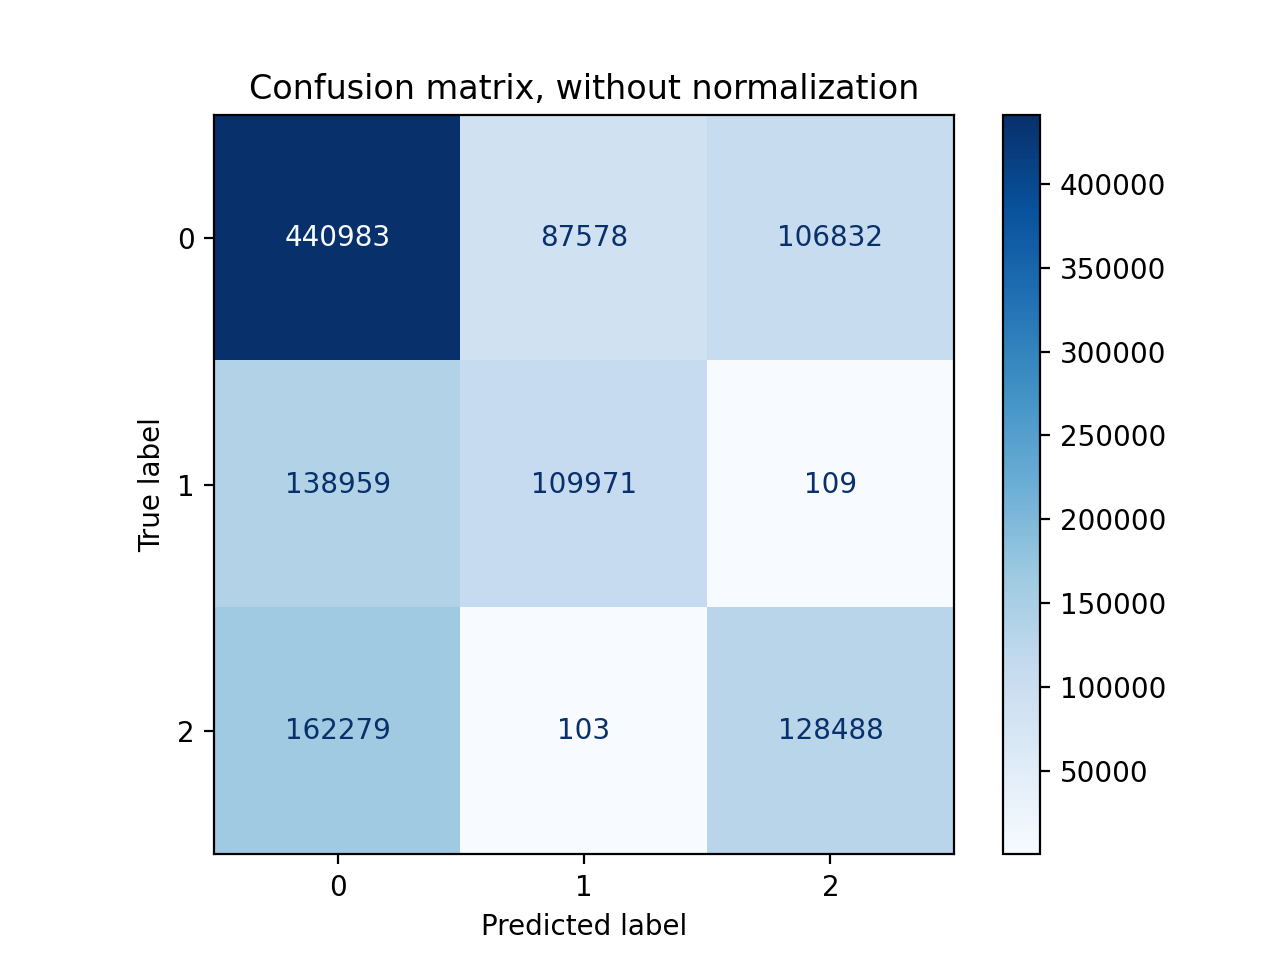

Confusion matrix, without normalization
[[440983  87578 106832]
 [138959 109971    109]
 [162279    103 128488]]


/home/student/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


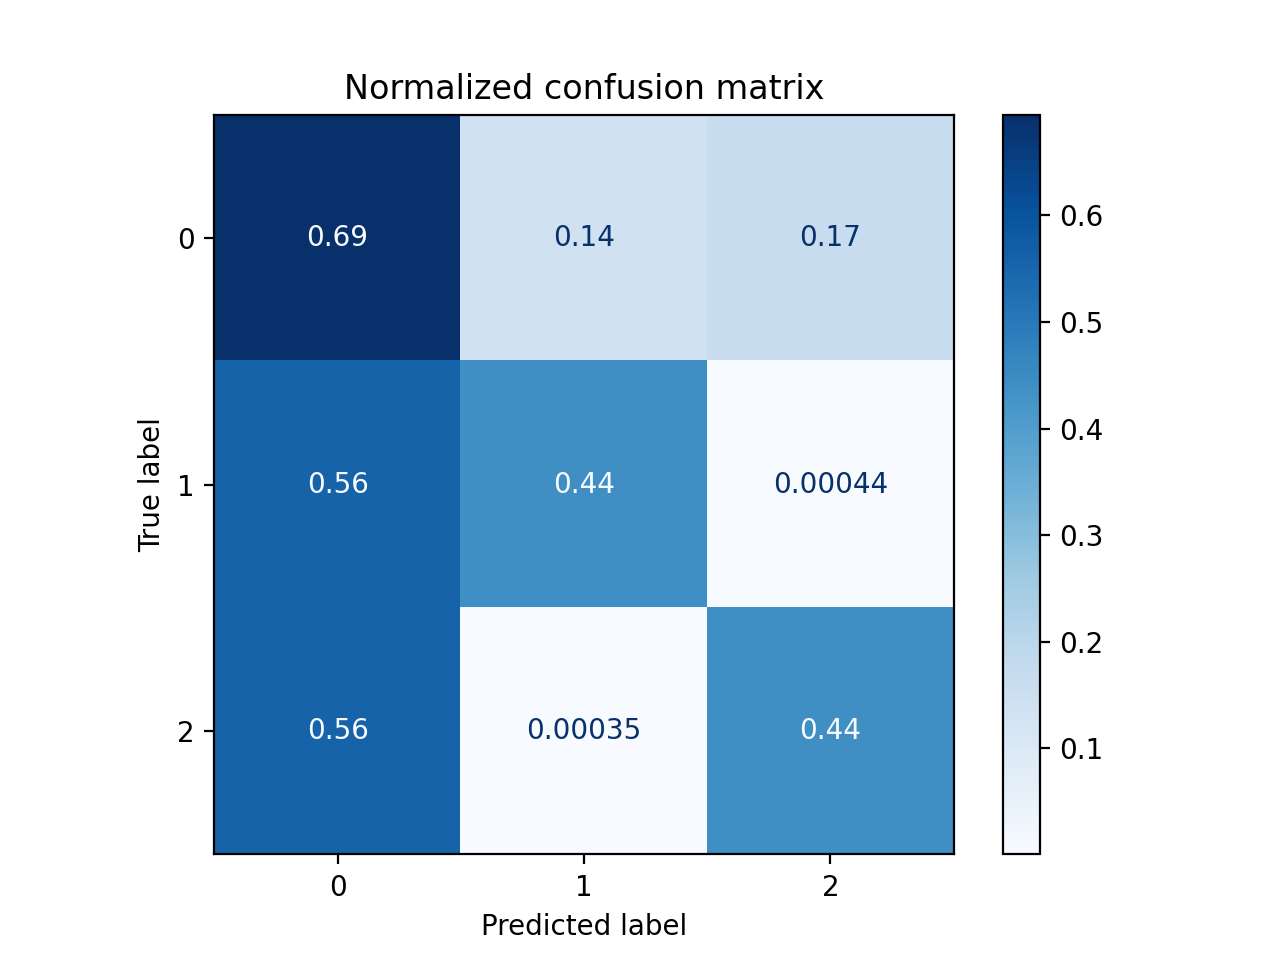

Normalized confusion matrix
[[6.94e-01 1.38e-01 1.68e-01]
 [5.58e-01 4.42e-01 4.38e-04]
 [5.58e-01 3.54e-04 4.42e-01]]
Train Acc: 0.5992144481596239, Train F1: 0.5915115125141495


<IPython.core.display.Javascript object>


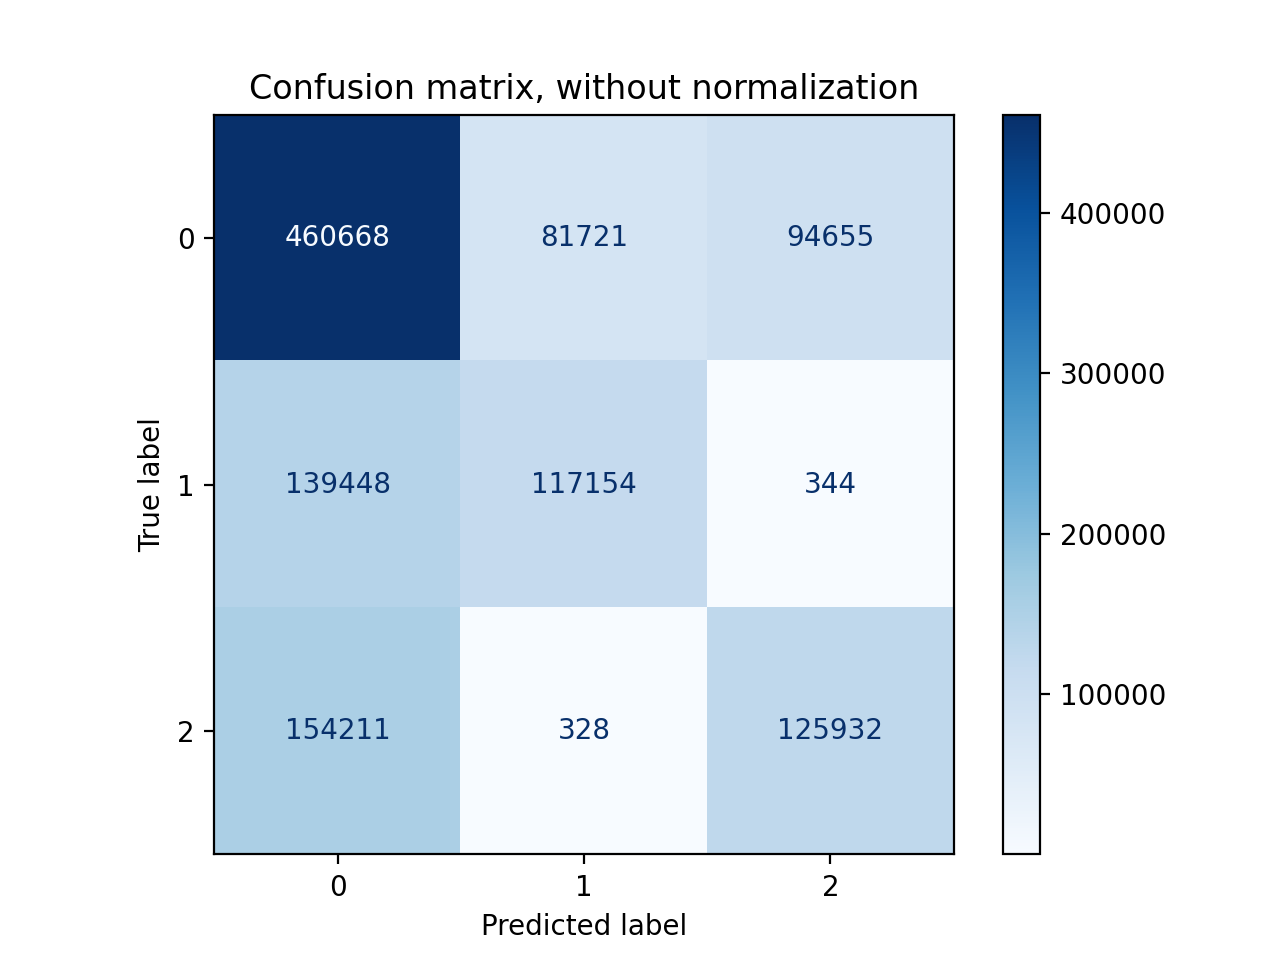

Confusion matrix, without normalization
[[460668  81721  94655]
 [139448 117154    344]
 [154211    328 125932]]


<IPython.core.display.Javascript object>


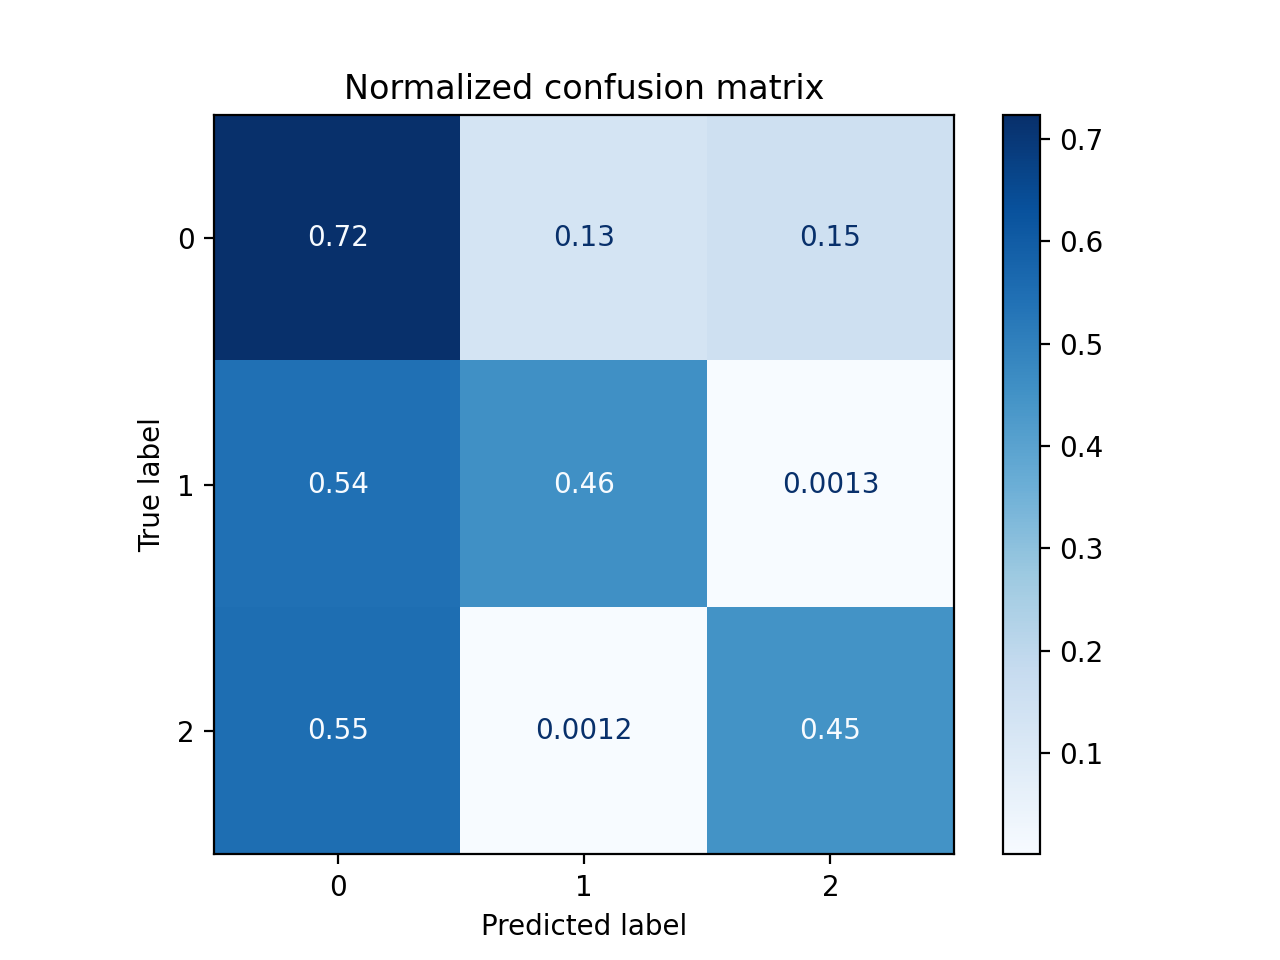

Normalized confusion matrix
[[0.72 0.13 0.15]
 [0.54 0.46 0.  ]
 [0.55 0.   0.45]]


In [52]:
file_name='gsearch_pca50'
with open(f'{file_name}.pkl', 'rb') as f:
    grid_search = pickle.load(f)
# print(f"{file_name} | CV Results: {grid_search.cv_results_}")
print(f"{file_name} | Best Param: {grid_search.best_params_}")
print(f"{file_name} | Best Score: {grid_search.best_score_}")
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=grid_search.best_estimator_, eval_data=X_test_pca50, eval_labels=eval_labels, train_data=X_train_pca50, train_labels=train_labels)

### Compress the dataset into 20 dimensions with PCA

In [47]:
X_train_pca20, X_test_pca20 = pca_trans(n_components=20, X_train=train_data_sc, X_test=eval_data_sc)
xgb_gridsearch(params=param_pca, file_name='gsearch_pca20', X_train=X_train_pca20, y_train=train_labels)

(1174461, 20)
[[ 1.77 -2.45  2.28 ... -0.31  0.22 -0.42]
 [ 2.17 -0.4   3.4  ... -0.09  1.78  0.27]
 [ 1.59  0.72  2.34 ...  0.33  3.56 -0.06]
 ...
 [ 3.05  3.25 -1.09 ... -0.5   0.02  0.8 ]
 [ 2.59  4.3  -0.85 ...  0.04 -0.45  0.05]
 [ 0.81  2.07 -2.4  ... -0.56  0.42  0.06]]
Value Range: [-41.1768963386914:235.34429715420234]
gsearch_pca20 | Best Param: {'max_depth': 10}
gsearch_pca20 | Best Score: 0.5618430596329118


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1, param_grid={'max_depth': [5, 10, 15, 20]},
             scoring='f1_weighted')

gsearch_pca20 | Best Param: {'max_depth': 10}
gsearch_pca20 | Best Score: 0.5618430596329118
Test Acc: 0.5701343144145079, Test F1: 0.5638357971574556


<IPython.core.display.Javascript object>


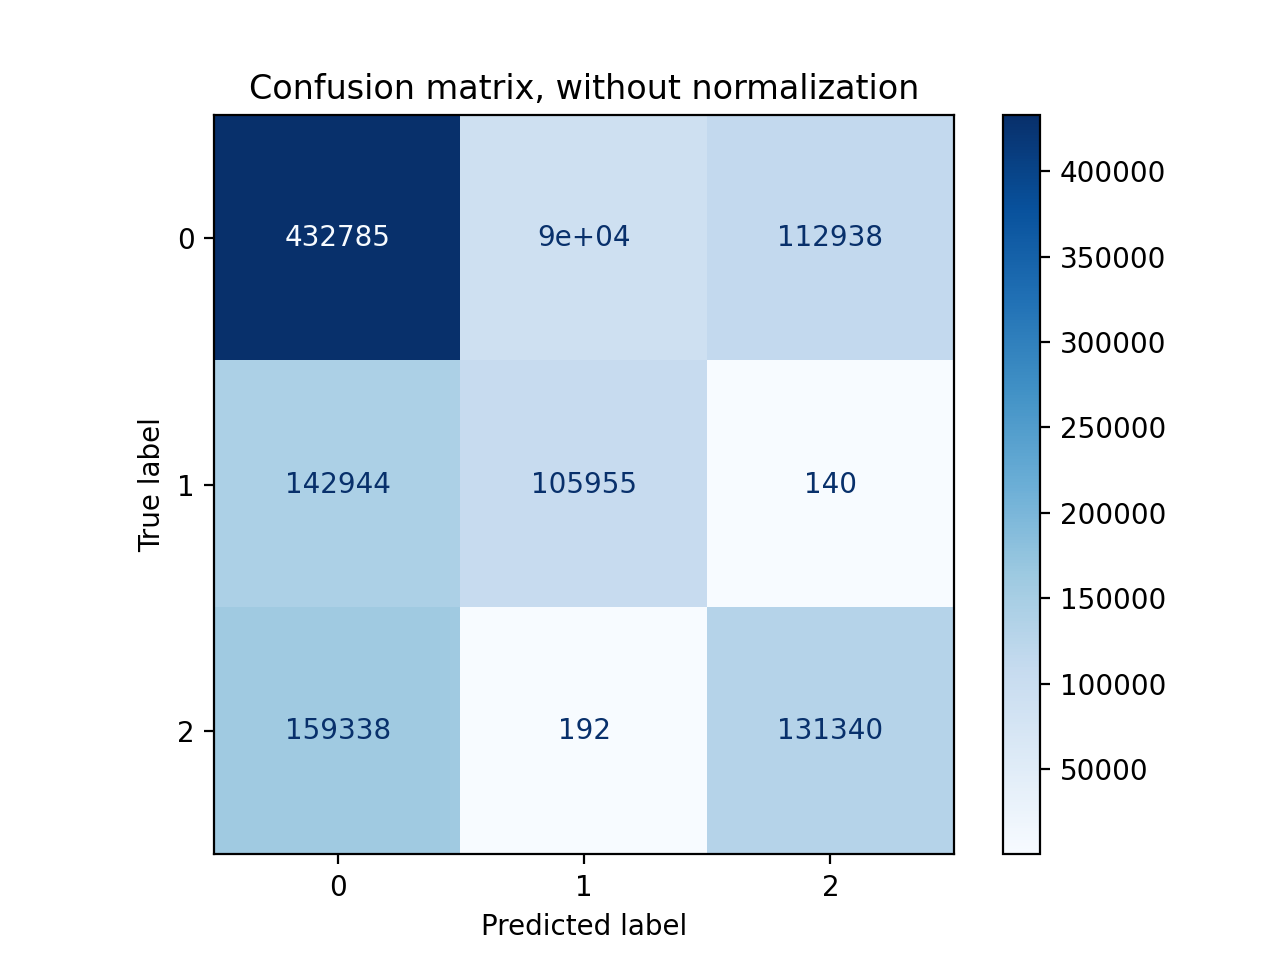

Confusion matrix, without normalization
[[432785  89670 112938]
 [142944 105955    140]
 [159338    192 131340]]


<IPython.core.display.Javascript object>


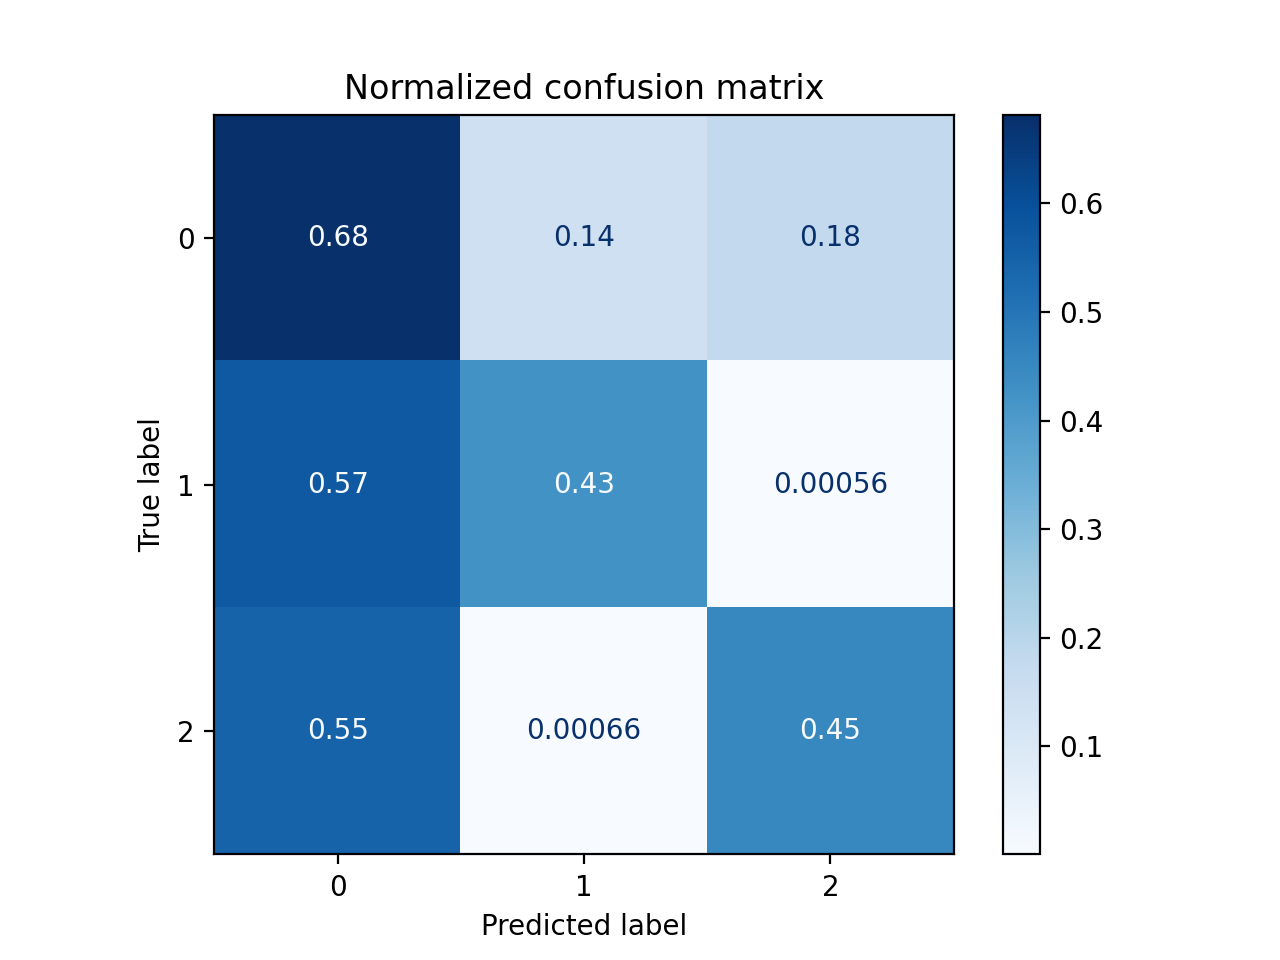

Normalized confusion matrix
[[6.81e-01 1.41e-01 1.78e-01]
 [5.74e-01 4.25e-01 5.62e-04]
 [5.48e-01 6.60e-04 4.52e-01]]
Train Acc: 0.7334198411015777, Train F1: 0.7303768994044737


<IPython.core.display.Javascript object>


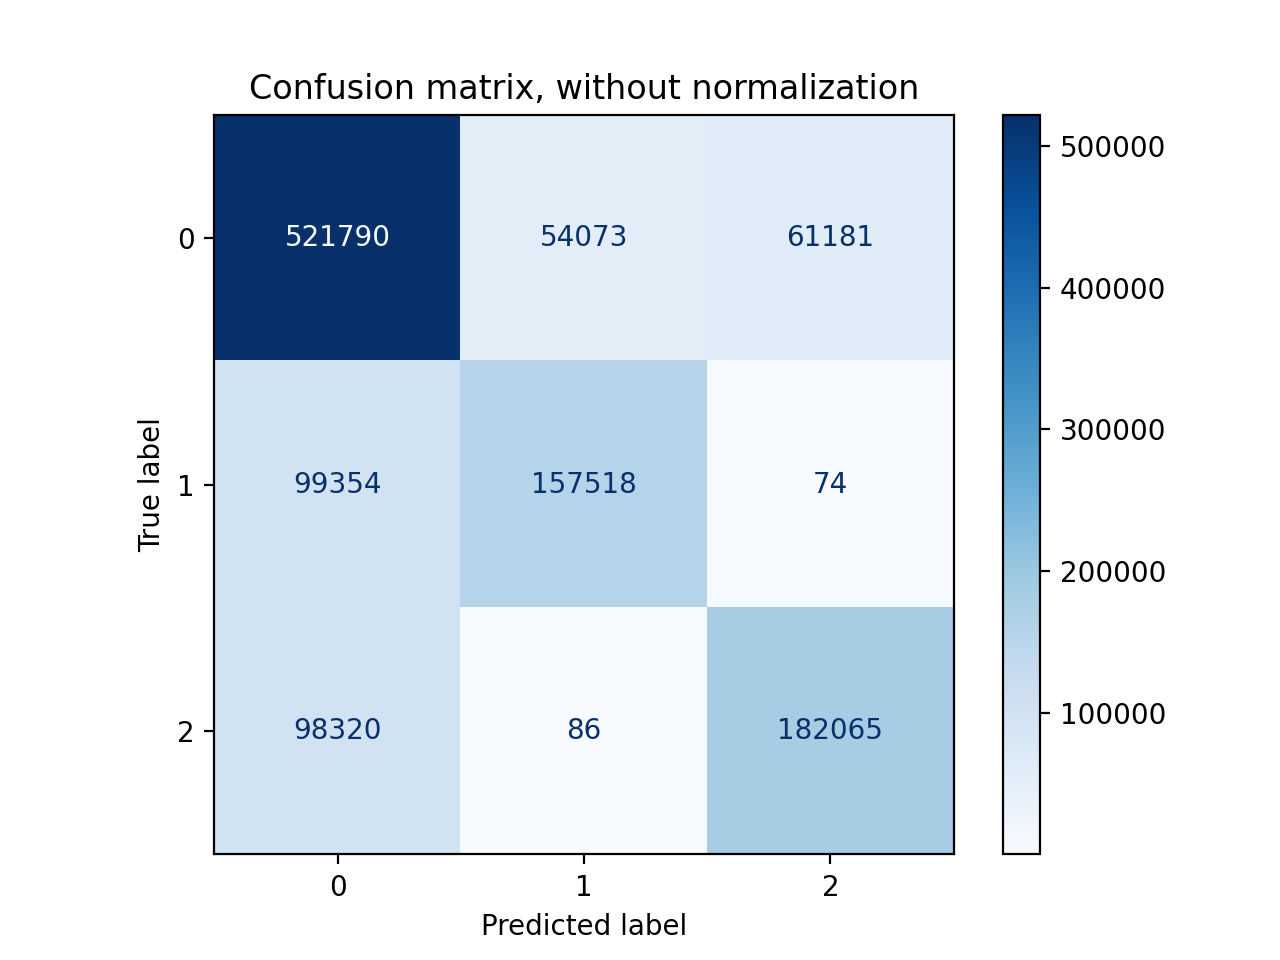

Confusion matrix, without normalization
[[521790  54073  61181]
 [ 99354 157518     74]
 [ 98320     86 182065]]


<IPython.core.display.Javascript object>


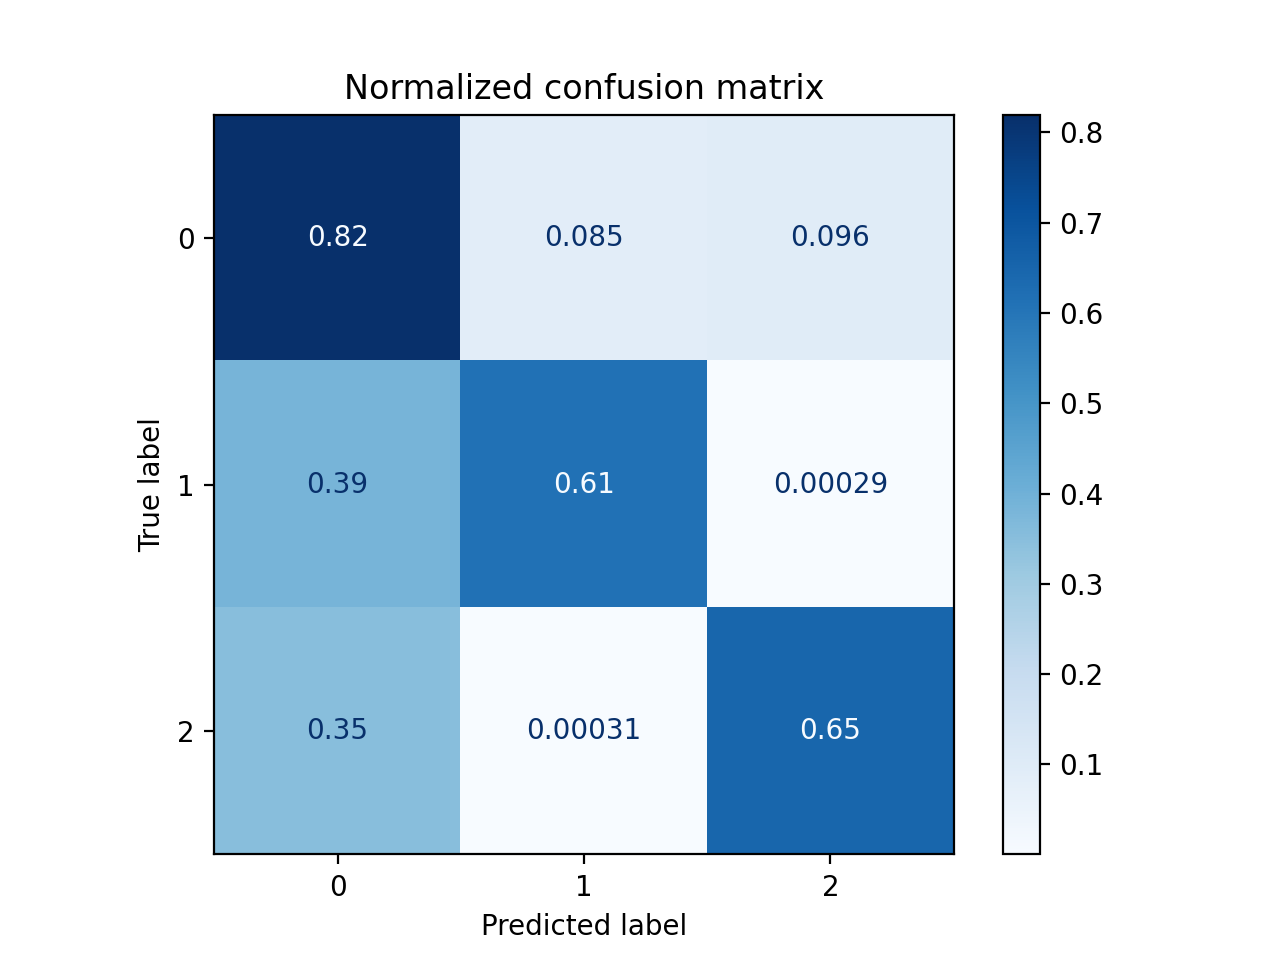

Normalized confusion matrix
[[8.19e-01 8.49e-02 9.60e-02]
 [3.87e-01 6.13e-01 2.88e-04]
 [3.51e-01 3.07e-04 6.49e-01]]


In [53]:
file_name='gsearch_pca20'
with open(f'{file_name}.pkl', 'rb') as f:
    grid_search = pickle.load(f)
# print(f"{file_name} | CV Results: {grid_search.cv_results_}")
print(f"{file_name} | Best Param: {grid_search.best_params_}")
print(f"{file_name} | Best Score: {grid_search.best_score_}")
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=grid_search.best_estimator_, eval_data=X_test_pca20, eval_labels=eval_labels, train_data=X_train_pca20, train_labels=train_labels)

### Compress the dataset into 10 dimensions with PCA

In [48]:
X_train_pca10, X_test_pca10 = pca_trans(n_components=10, X_train=train_data_sc, X_test=eval_data_sc)
xgb_gridsearch(params=param_pca, file_name='gsearch_pca10', X_train=X_train_pca10, y_train=train_labels)

(1174461, 10)
[[ 1.77 -2.45  2.28 ...  0.6   1.76  1.57]
 [ 2.17 -0.4   3.4  ... -0.02  1.08  0.48]
 [ 1.59  0.72  2.34 ...  0.08 -1.21  0.14]
 ...
 [ 3.05  3.25 -1.09 ...  0.95  0.98  0.1 ]
 [ 2.59  4.3  -0.85 ... -1.88  1.31 -0.48]
 [ 0.81  2.07 -2.4  ... -1.53 -1.9   2.32]]
Value Range: [-18.448204764796845:208.93814057705578]
gsearch_pca10 | Best Param: {'max_depth': 10}
gsearch_pca10 | Best Score: 0.5509259180256822


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1, param_grid={'max_depth': [5, 10, 15, 20]},
             scoring='f1_weighted')

gsearch_pca10 | Best Param: {'max_depth': 10}
gsearch_pca10 | Best Score: 0.5509259180256822
Test Acc: 0.5610047460142159, Test F1: 0.5507090965422968


<IPython.core.display.Javascript object>


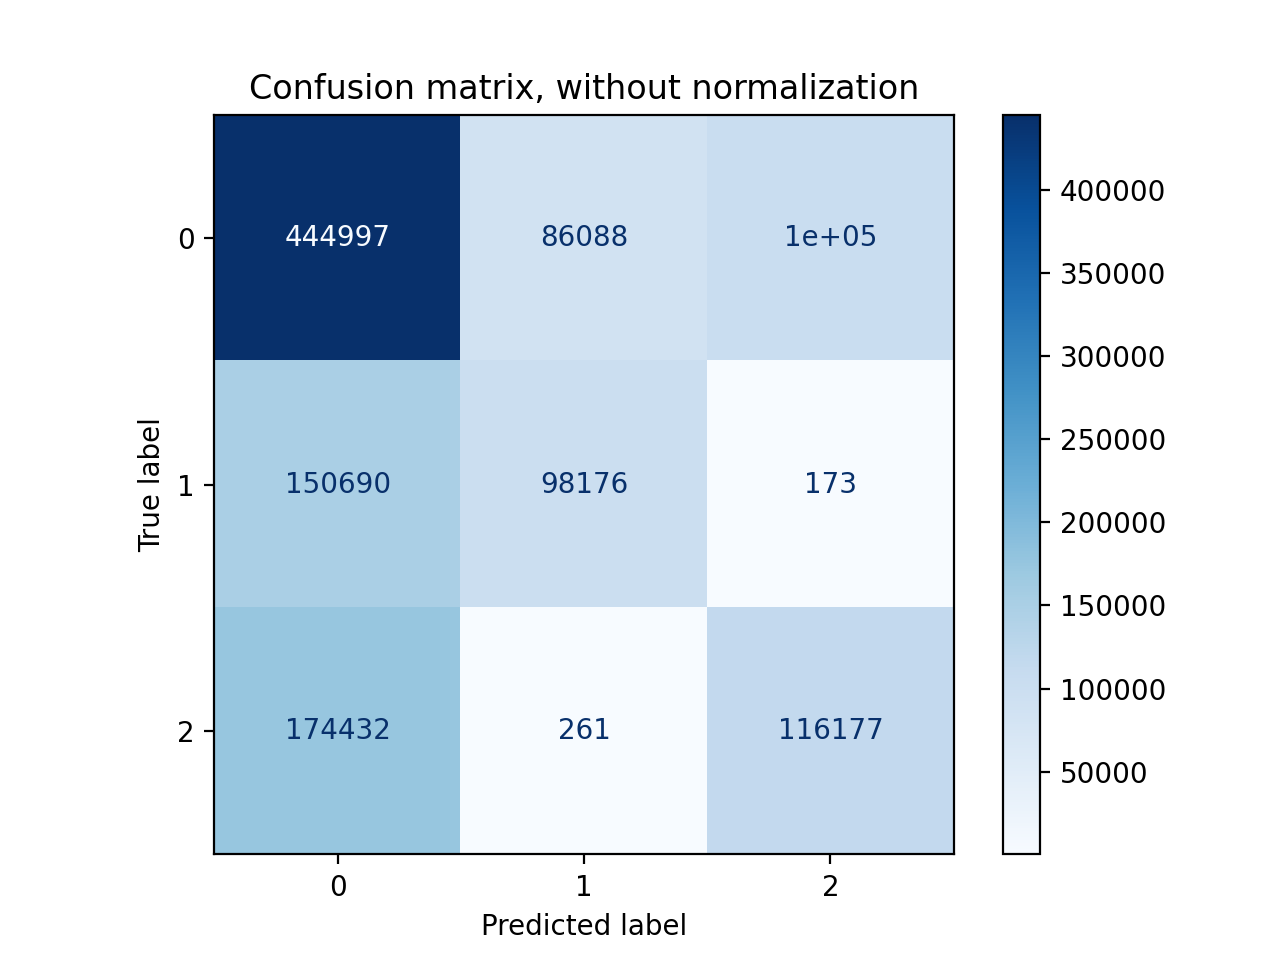

Confusion matrix, without normalization
[[444997  86088 104308]
 [150690  98176    173]
 [174432    261 116177]]


<IPython.core.display.Javascript object>


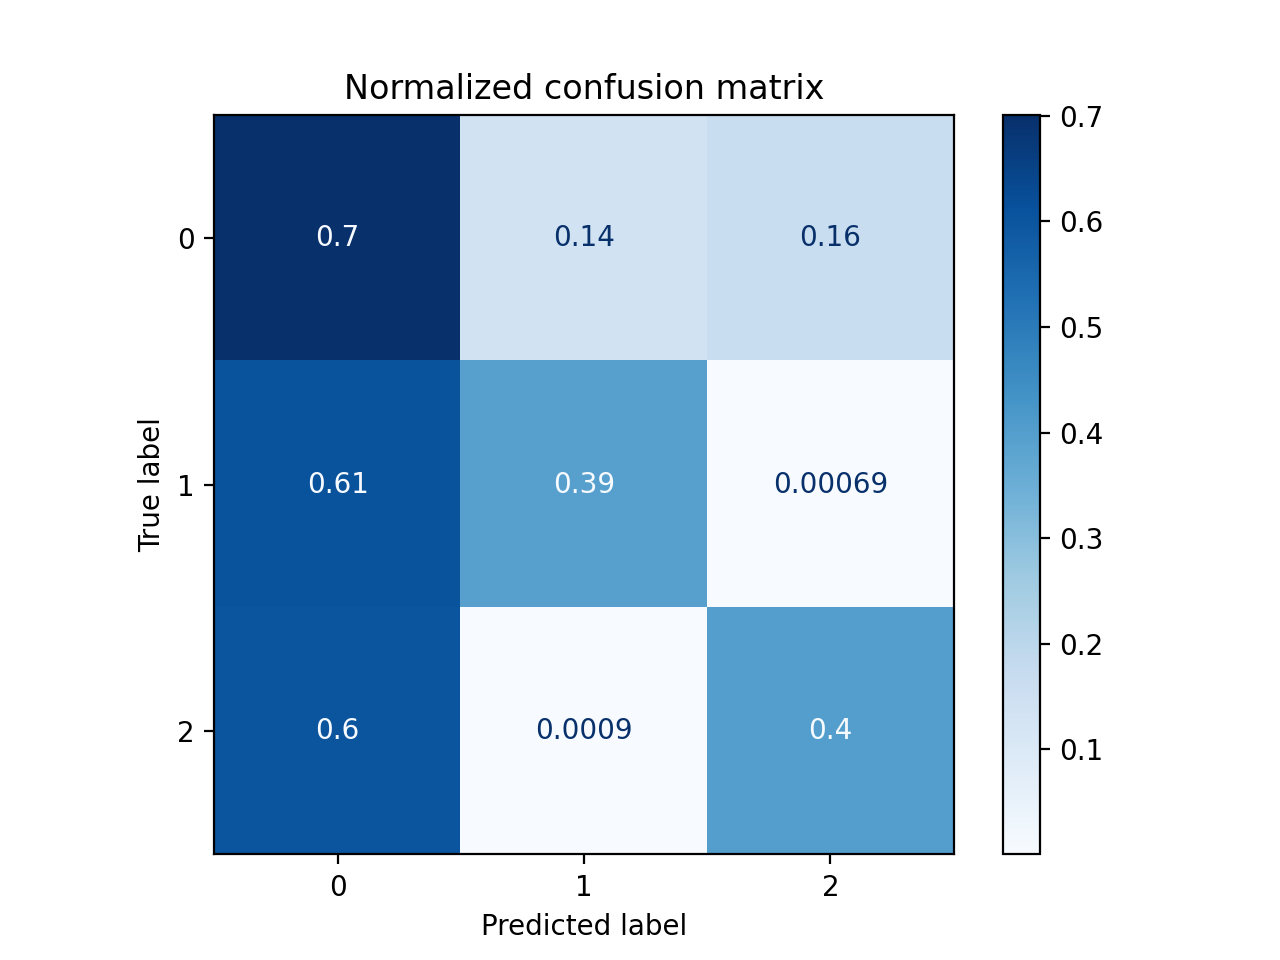

Normalized confusion matrix
[[7.00e-01 1.35e-01 1.64e-01]
 [6.05e-01 3.94e-01 6.95e-04]
 [6.00e-01 8.97e-04 3.99e-01]]
Train Acc: 0.7021144167409561, Train F1: 0.6951831768468268


<IPython.core.display.Javascript object>


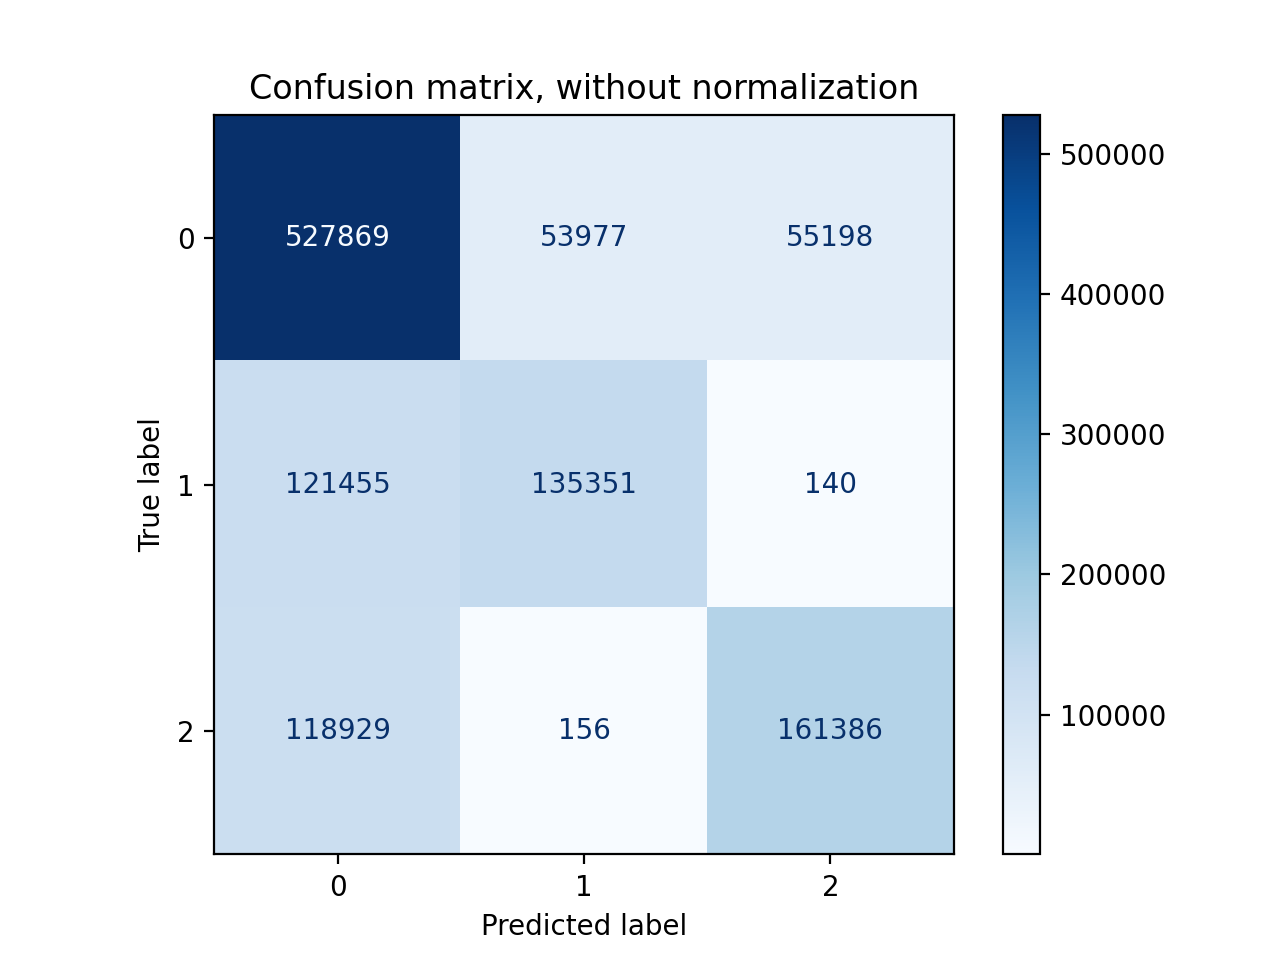

Confusion matrix, without normalization
[[527869  53977  55198]
 [121455 135351    140]
 [118929    156 161386]]


<IPython.core.display.Javascript object>


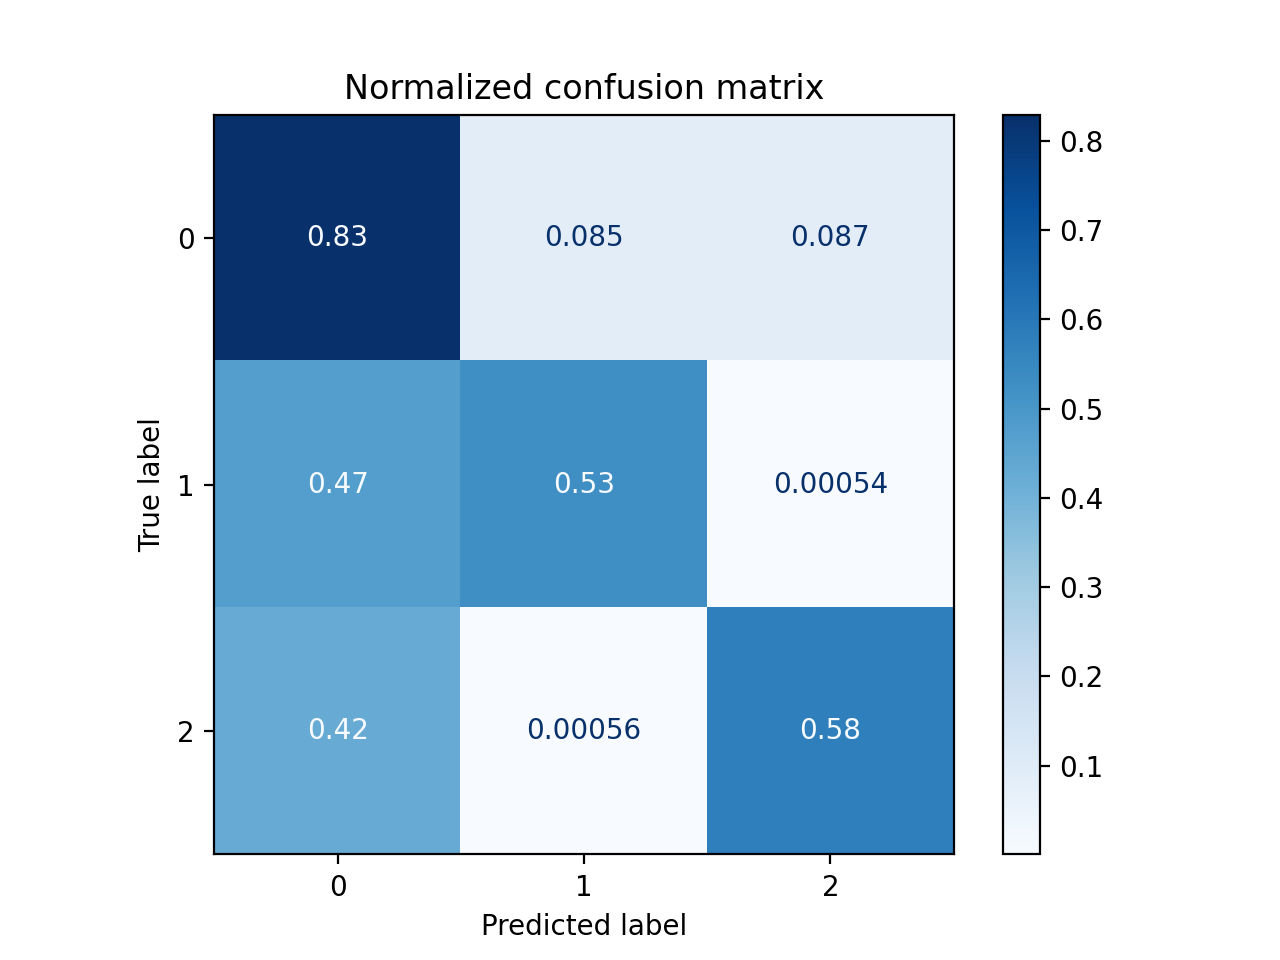

Normalized confusion matrix
[[8.29e-01 8.47e-02 8.66e-02]
 [4.73e-01 5.27e-01 5.45e-04]
 [4.24e-01 5.56e-04 5.75e-01]]


In [54]:
file_name='gsearch_pca10'
with open(f'{file_name}.pkl', 'rb') as f:
    grid_search = pickle.load(f)
# print(f"{file_name} | CV Results: {grid_search.cv_results_}")
print(f"{file_name} | Best Param: {grid_search.best_params_}")
print(f"{file_name} | Best Score: {grid_search.best_score_}")
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=grid_search.best_estimator_, eval_data=X_test_pca10, eval_labels=eval_labels, train_data=X_train_pca10, train_labels=train_labels)

# Check Compressed Dataset with More Complex Model
Check the 10-dimensions dataset with 20 max_depth XGBoost forest. However, I found it would overfitting severely.

In [10]:
xgboostModel = XGBClassifier(n_estimators=100, max_depth=20)
xgboostModel.fit(X_train_pca10, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Importance Analysis
As we can see, PCA only keep important dimensions

<IPython.core.display.Javascript object>


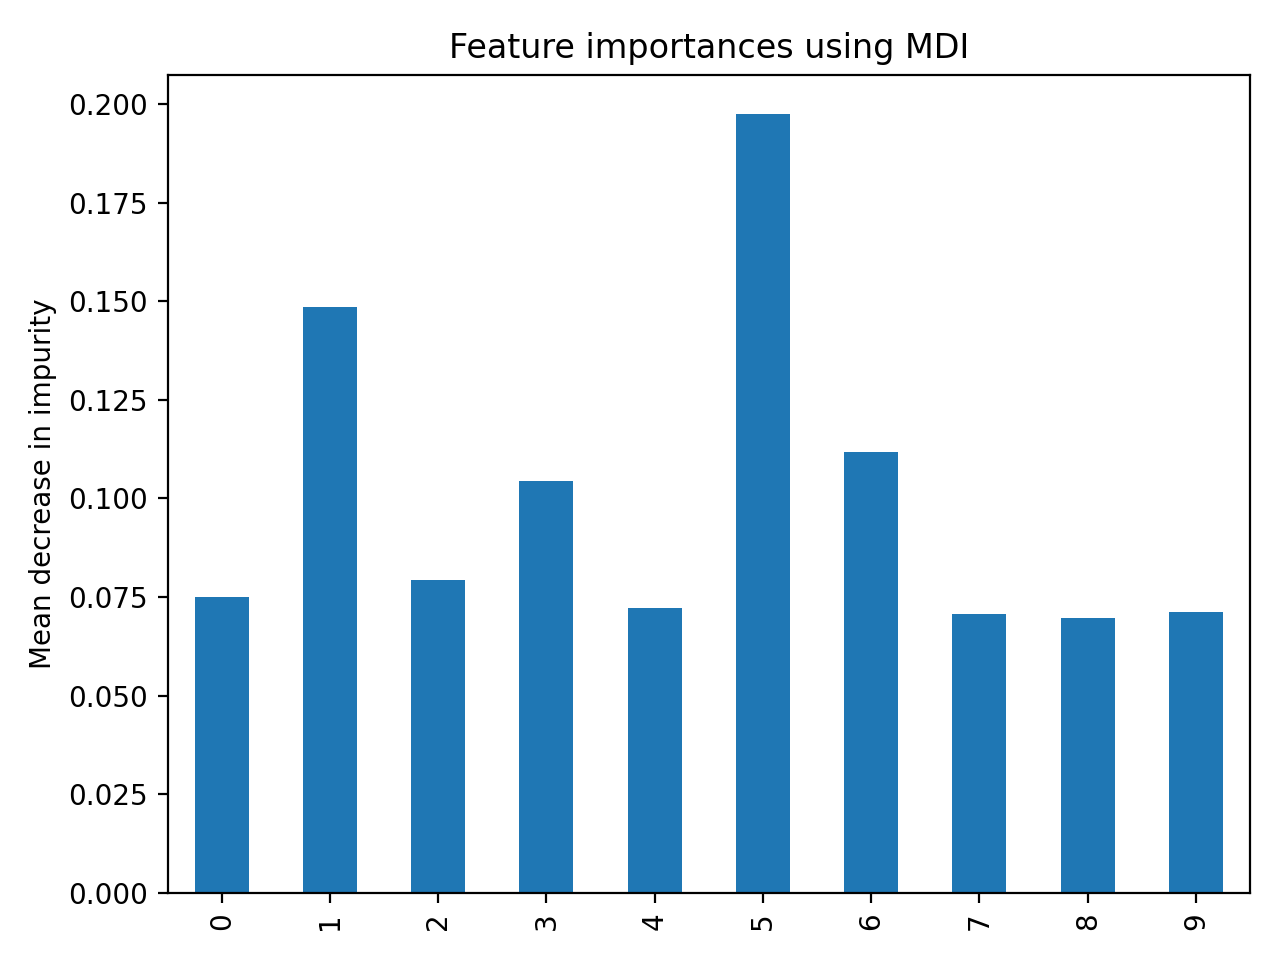

In [11]:
importances = xgboostModel.feature_importances_
plot_importance(importances=importances)

## Overfitting
Still overfitting on 10-dimension dataset. The model get 100% accuracy and F1 score in training dataset but 54% in testing dataset.

Test Acc: 0.5472125462221624, Test F1: 0.5405697281732865


<IPython.core.display.Javascript object>


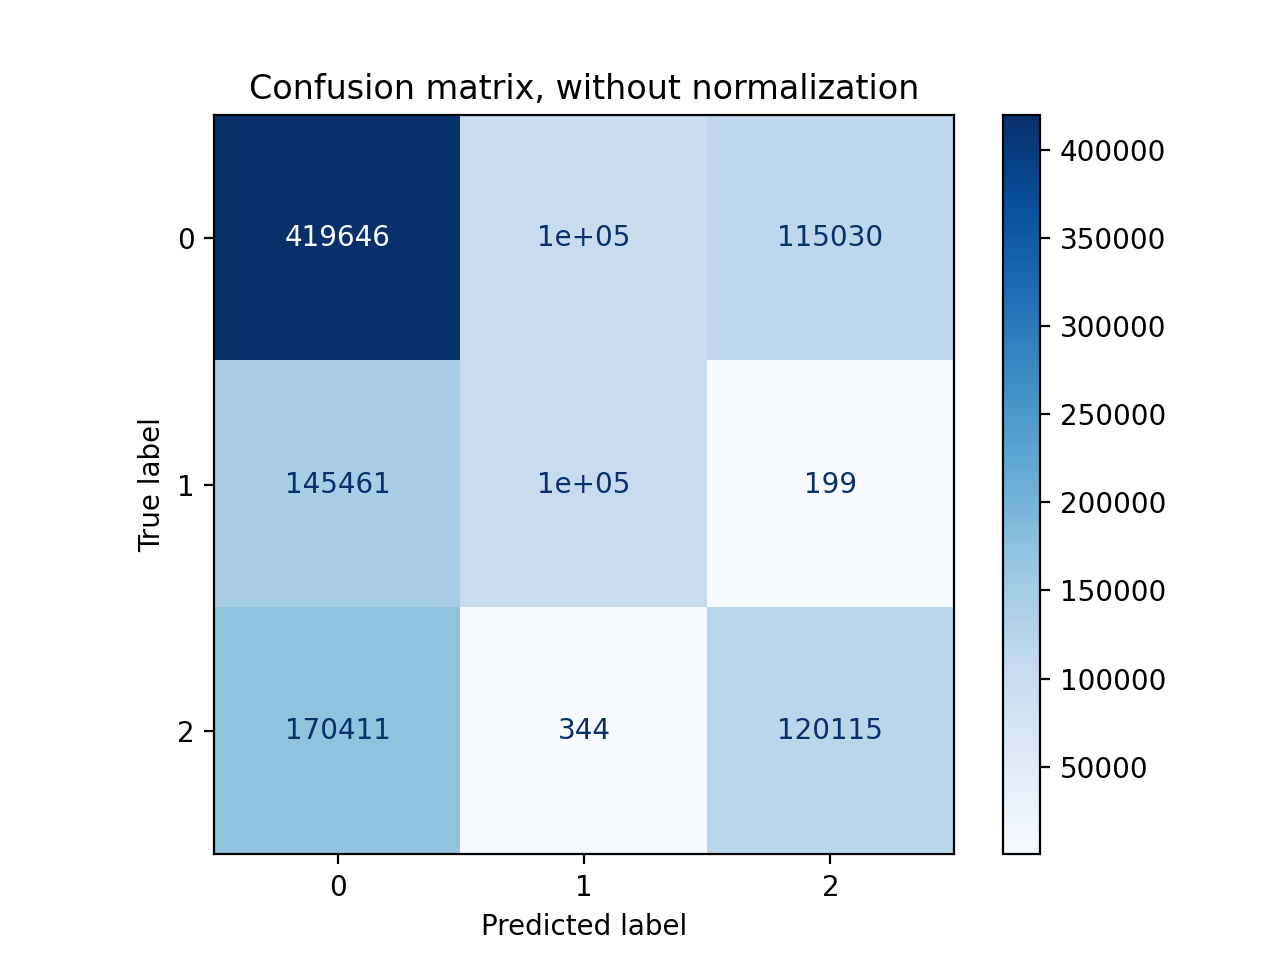

Confusion matrix, without normalization
[[419646 100717 115030]
 [145461 103379    199]
 [170411    344 120115]]


<IPython.core.display.Javascript object>


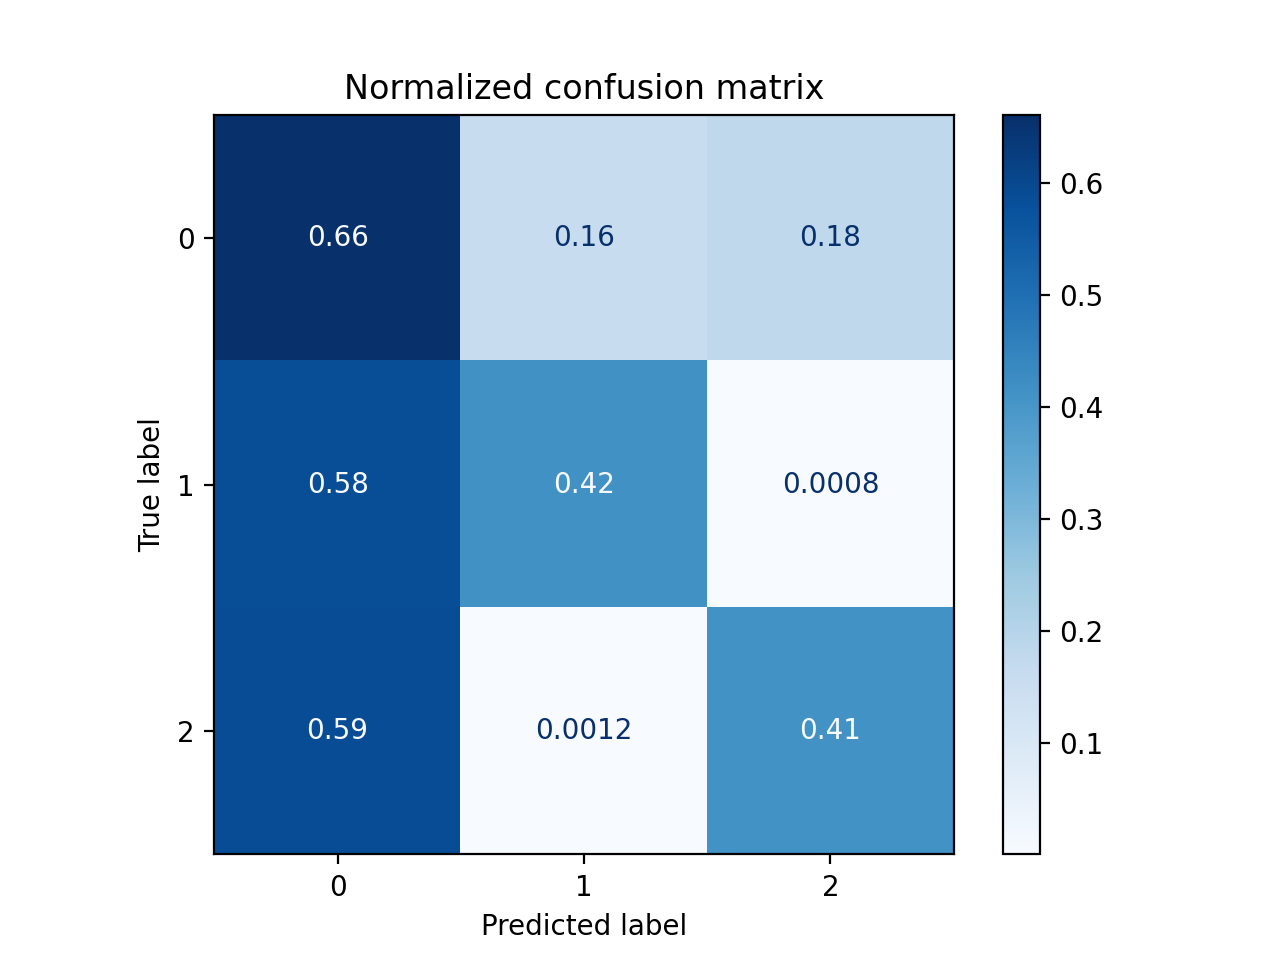

Normalized confusion matrix
[[0.66 0.16 0.18]
 [0.58 0.42 0.  ]
 [0.59 0.   0.41]]
Train Acc: 0.9999684961867614, Train F1: 0.9999684960161487


<IPython.core.display.Javascript object>


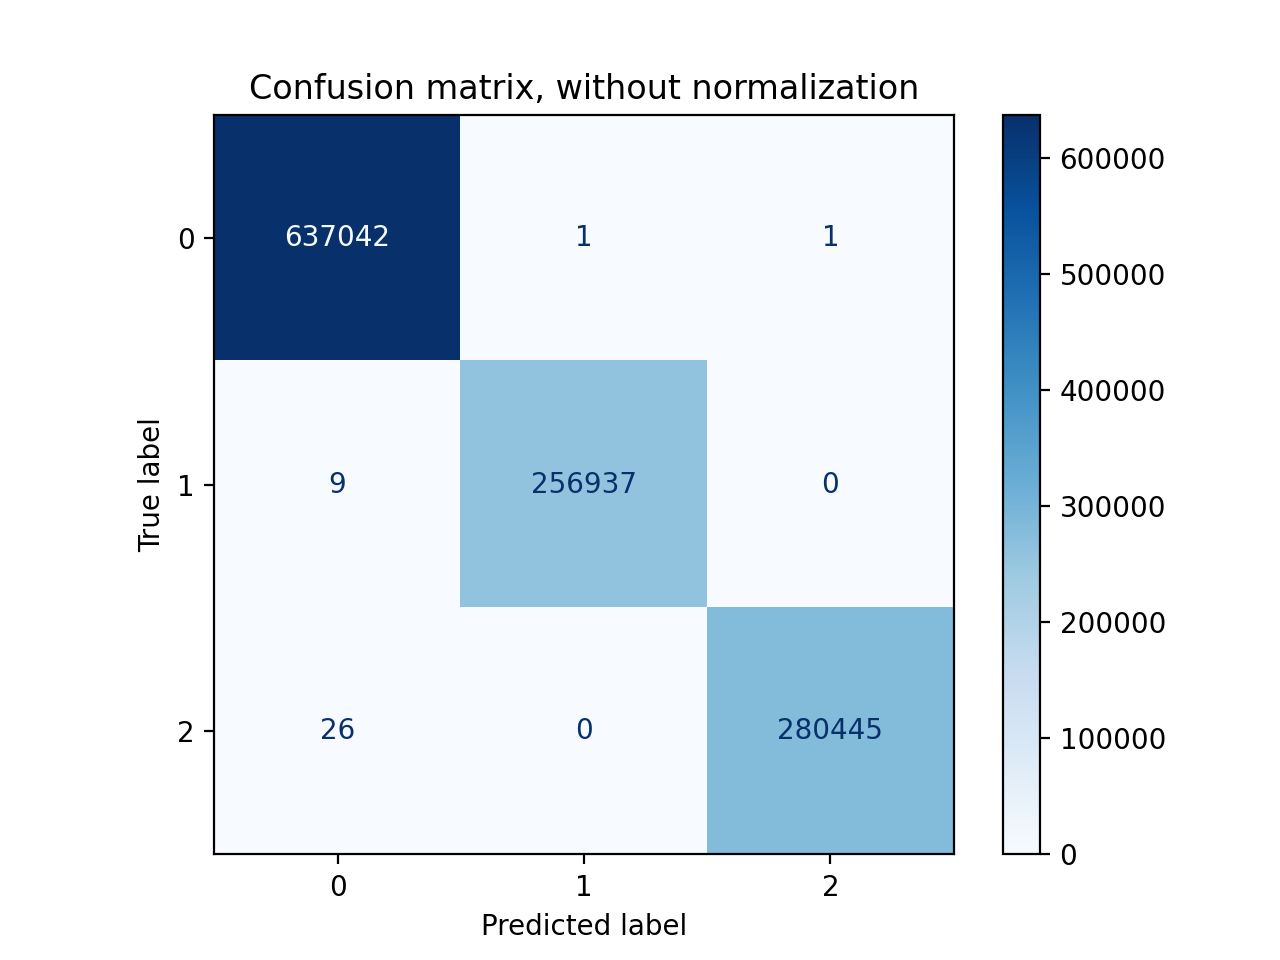

Confusion matrix, without normalization
[[637042      1      1]
 [     9 256937      0]
 [    26      0 280445]]


<IPython.core.display.Javascript object>


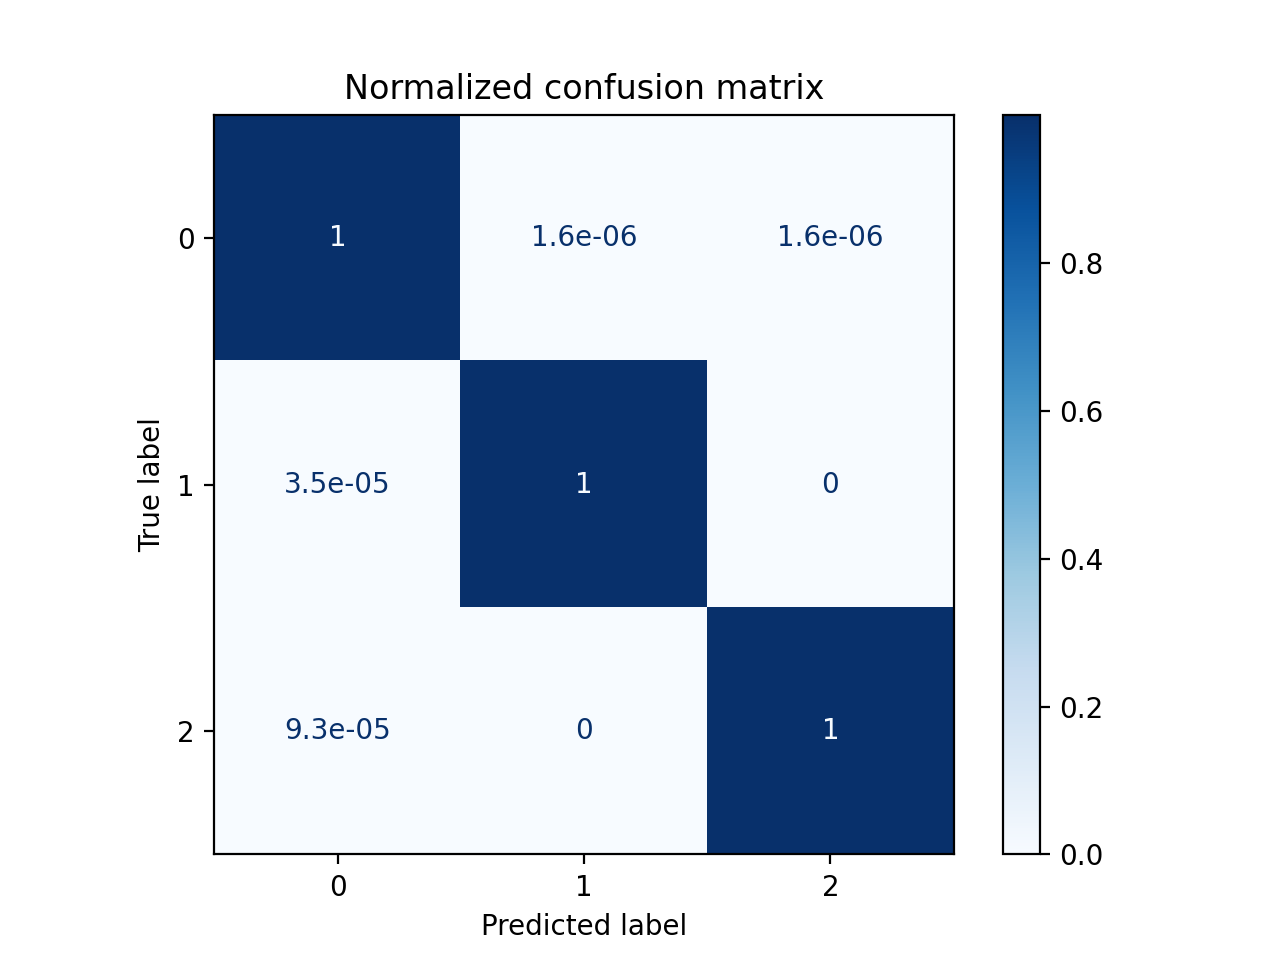

Normalized confusion matrix
[[1.00e+00 1.57e-06 1.57e-06]
 [3.50e-05 1.00e+00 0.00e+00]
 [9.27e-05 0.00e+00 1.00e+00]]


In [12]:
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=xgboostModel, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=train_data_sc, train_labels=train_labels)

# Ridge Classifier
I found that Ridge Classifier presents the same overfitting on the dataset. XGBoost would tend to classify the samples as class 0 but the Ridge classifier would tend to classify them as class 1 and 2.

Test Acc: 0.4743980696025362, Test F1: 0.33712751588397677


<IPython.core.display.Javascript object>


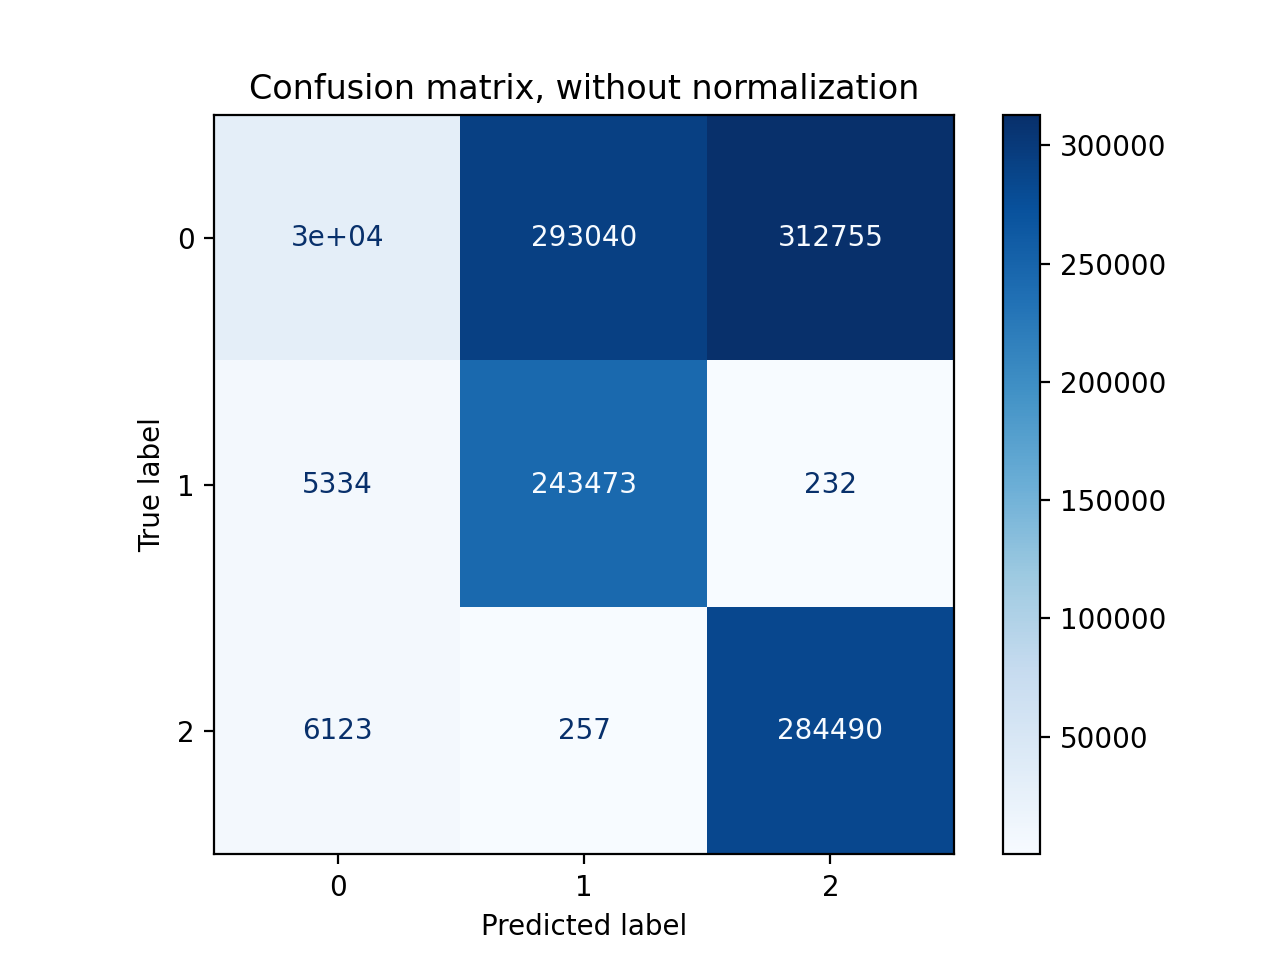

Confusion matrix, without normalization
[[ 29598 293040 312755]
 [  5334 243473    232]
 [  6123    257 284490]]


<IPython.core.display.Javascript object>


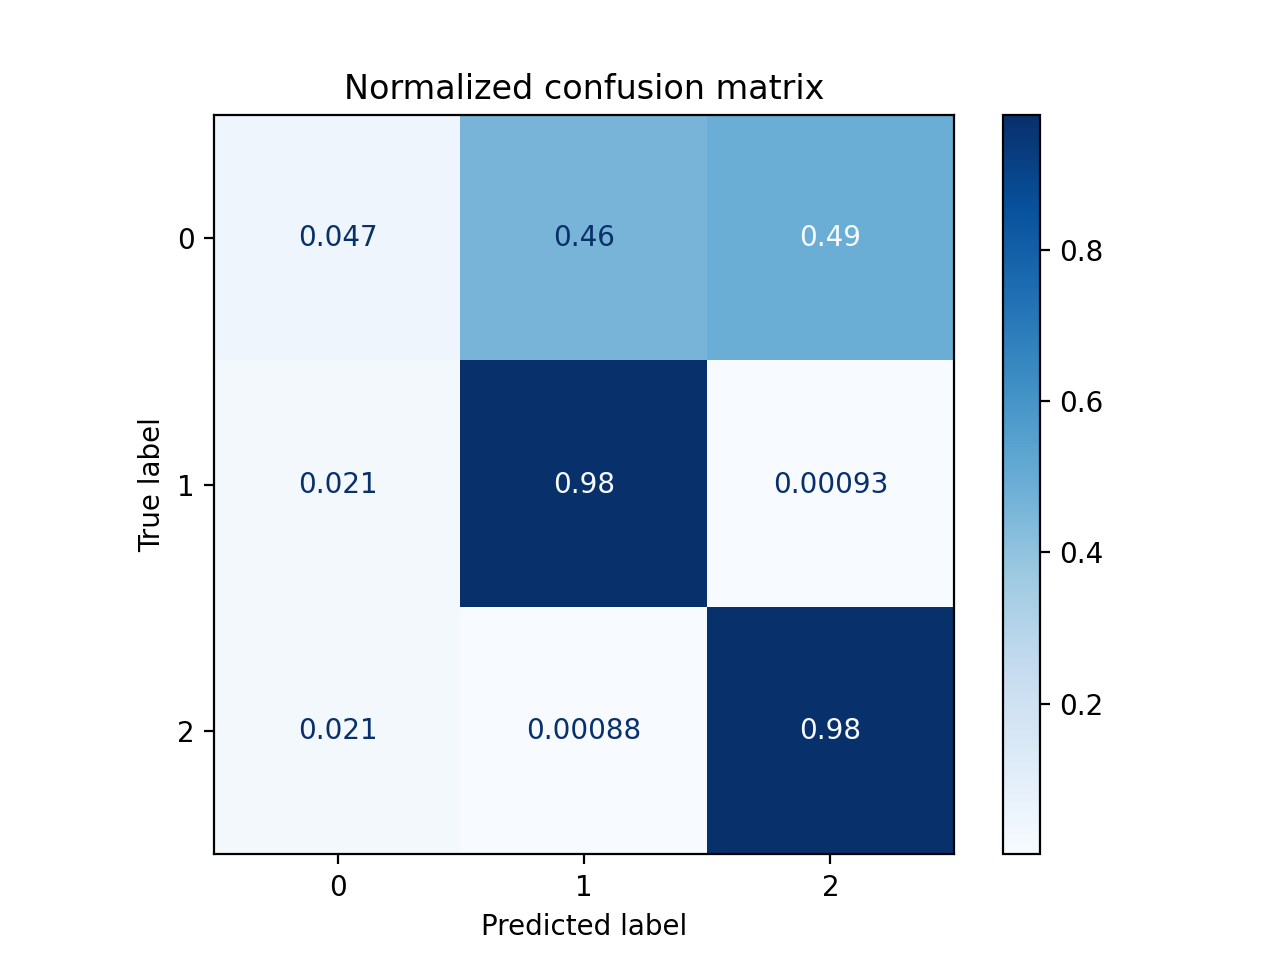

Normalized confusion matrix
[[4.66e-02 4.61e-01 4.92e-01]
 [2.14e-02 9.78e-01 9.32e-04]
 [2.11e-02 8.84e-04 9.78e-01]]
Train Acc: 0.4743903799274731, Train F1: 0.34259747343585


<IPython.core.display.Javascript object>


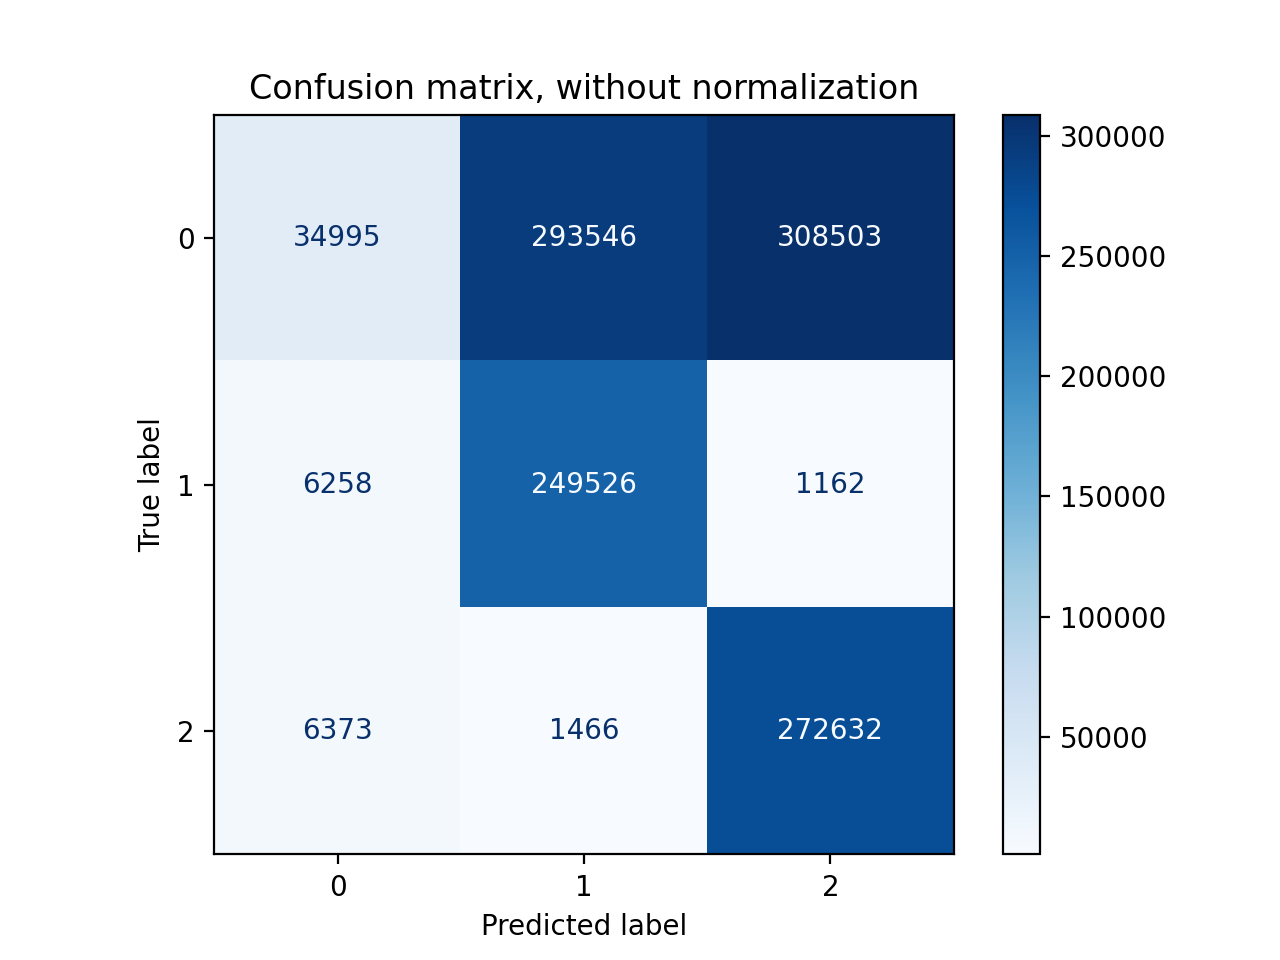

Confusion matrix, without normalization
[[ 34995 293546 308503]
 [  6258 249526   1162]
 [  6373   1466 272632]]


<IPython.core.display.Javascript object>


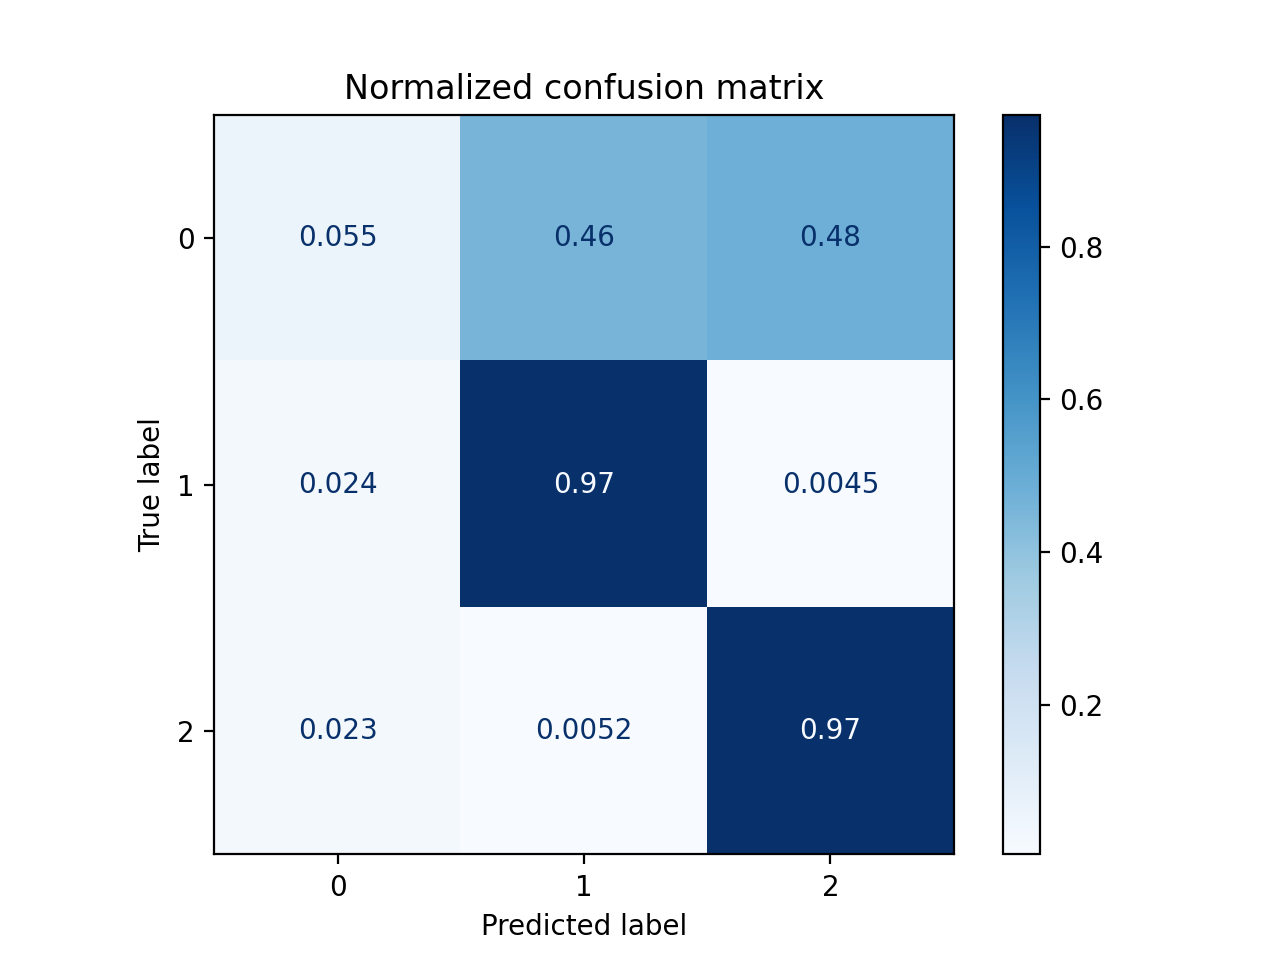

Normalized confusion matrix
[[0.05 0.46 0.48]
 [0.02 0.97 0.  ]
 [0.02 0.01 0.97]]


In [55]:
ridge_clf = RidgeClassifier(alpha=1, max_iter=10000, class_weight='balanced').fit(train_data_sc, train_labels)
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=ridge_clf, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=train_data_sc, train_labels=train_labels)

## (2) Outliners Filter
To eliminate the overfitting, I try Isolation Tree outliner filter to remove outliners. It yields a little bit performance enhancement, which is about 1% improvement on the accuracy and F1 score.

In [55]:
X_train_iso, y_train_iso = iso_trans(X_train=train_data_sc, y_train=train_labels)

(1164832, 70)
[[ 0.85 -0.71  0.14 ...  0.59  0.37  0.39]
 [ 1.13 -0.03  0.14 ...  0.59  0.37  0.39]
 [ 0.76 -0.03  0.14 ...  0.59  0.37  0.39]
 ...
 [ 0.33 -0.79 -0.24 ... -0.21 -0.18 -0.26]
 [ 0.33  1.54 -0.24 ... -0.21 -0.18 -0.26]
 [-0.69  0.02 -0.05 ... -0.21 -0.18 -0.26]]
Value Range: [-60.85795064477092:265.4388678920328]
(1164832,)
[1 1 0 ... 1 1 0]
Value Range: [0:2]


Test Acc: 0.5975298263765398, Test F1: 0.590251942382586


<IPython.core.display.Javascript object>


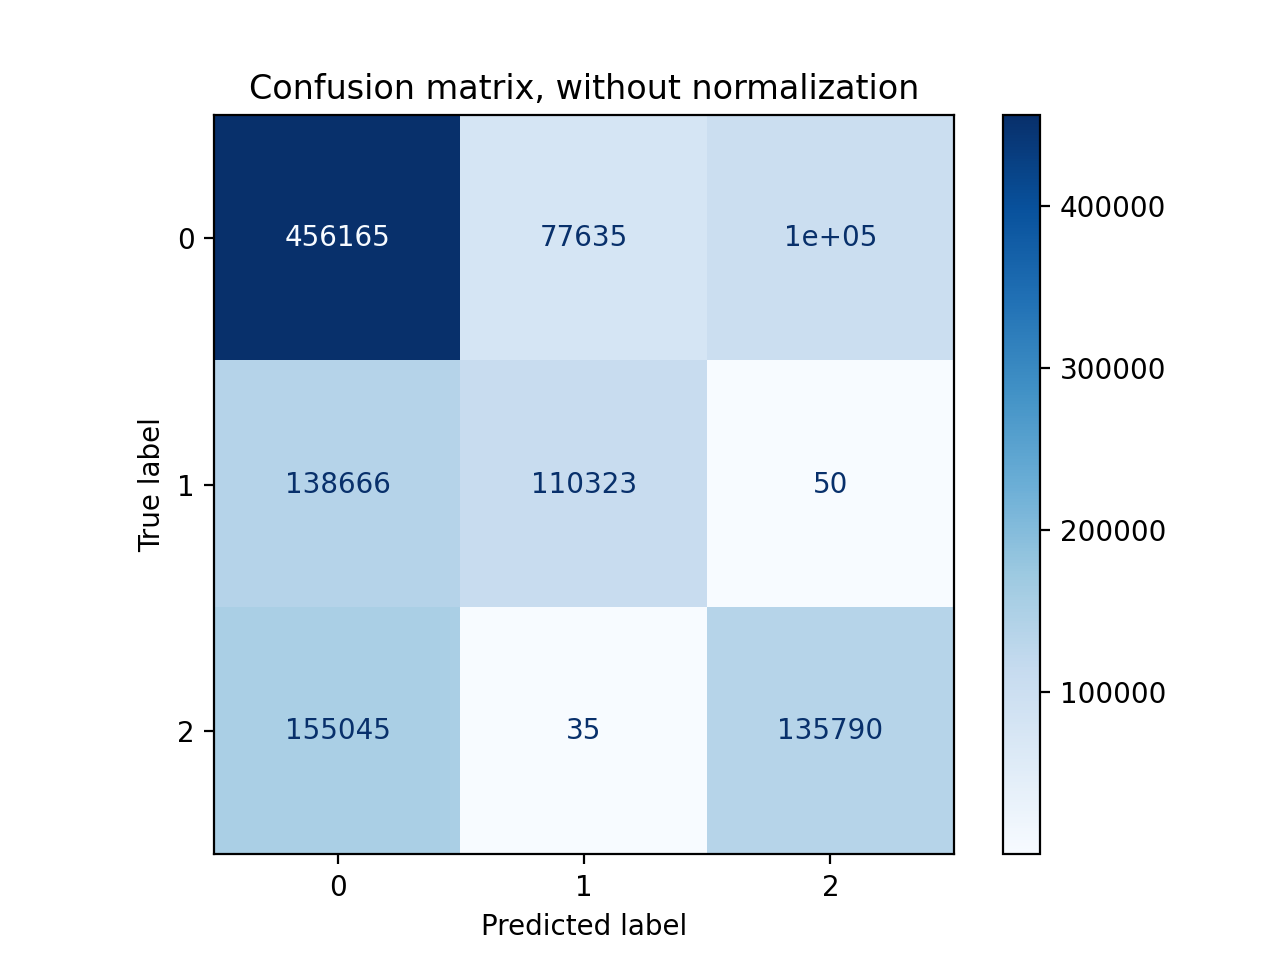

Confusion matrix, without normalization
[[456165  77635 101593]
 [138666 110323     50]
 [155045     35 135790]]


<IPython.core.display.Javascript object>


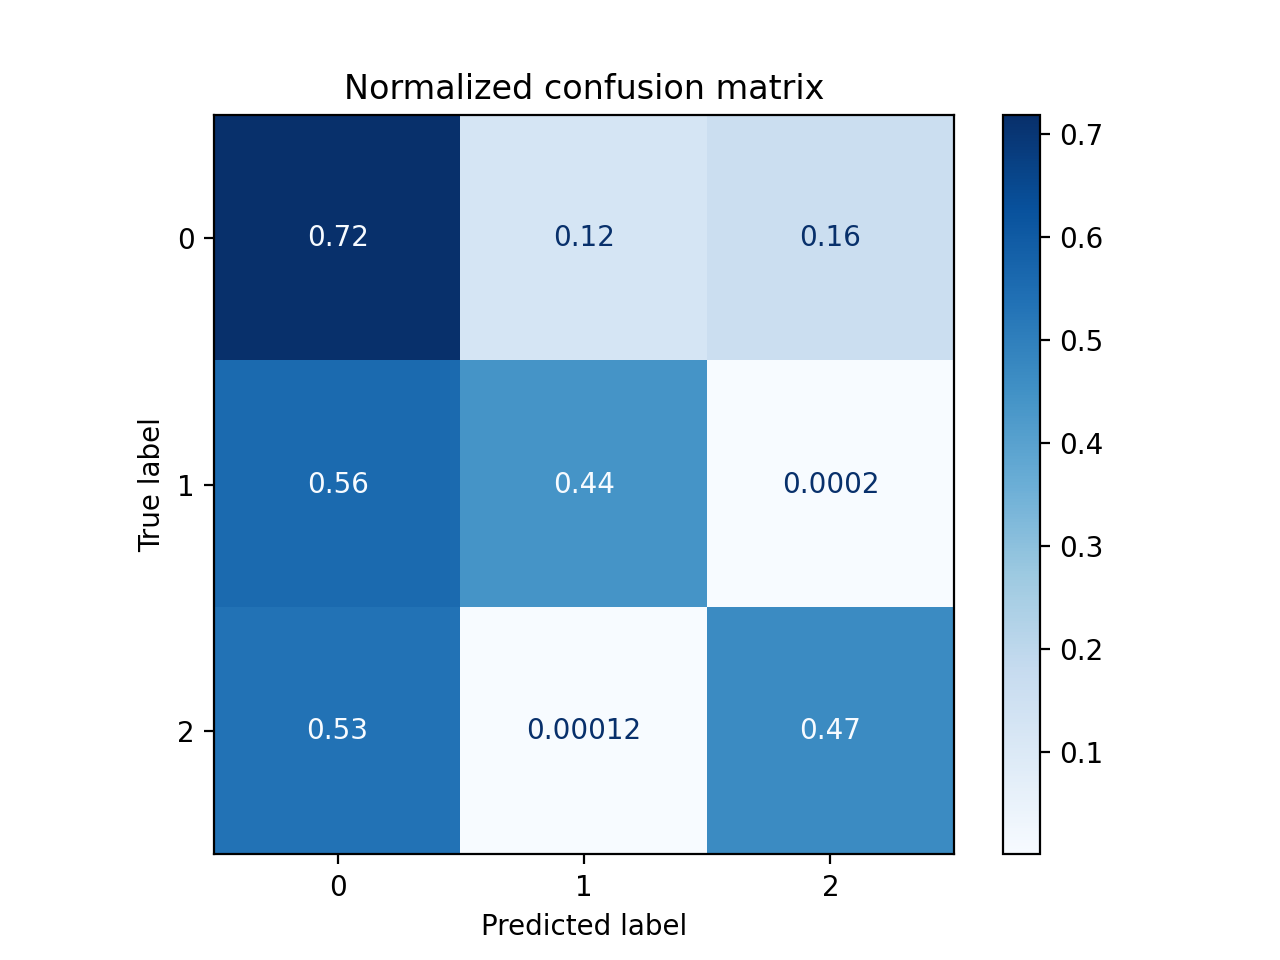

Normalized confusion matrix
[[7.18e-01 1.22e-01 1.60e-01]
 [5.57e-01 4.43e-01 2.01e-04]
 [5.33e-01 1.20e-04 4.67e-01]]
Train Acc: 0.6305501565891047, Train F1: 0.6259449667928779


<IPython.core.display.Javascript object>


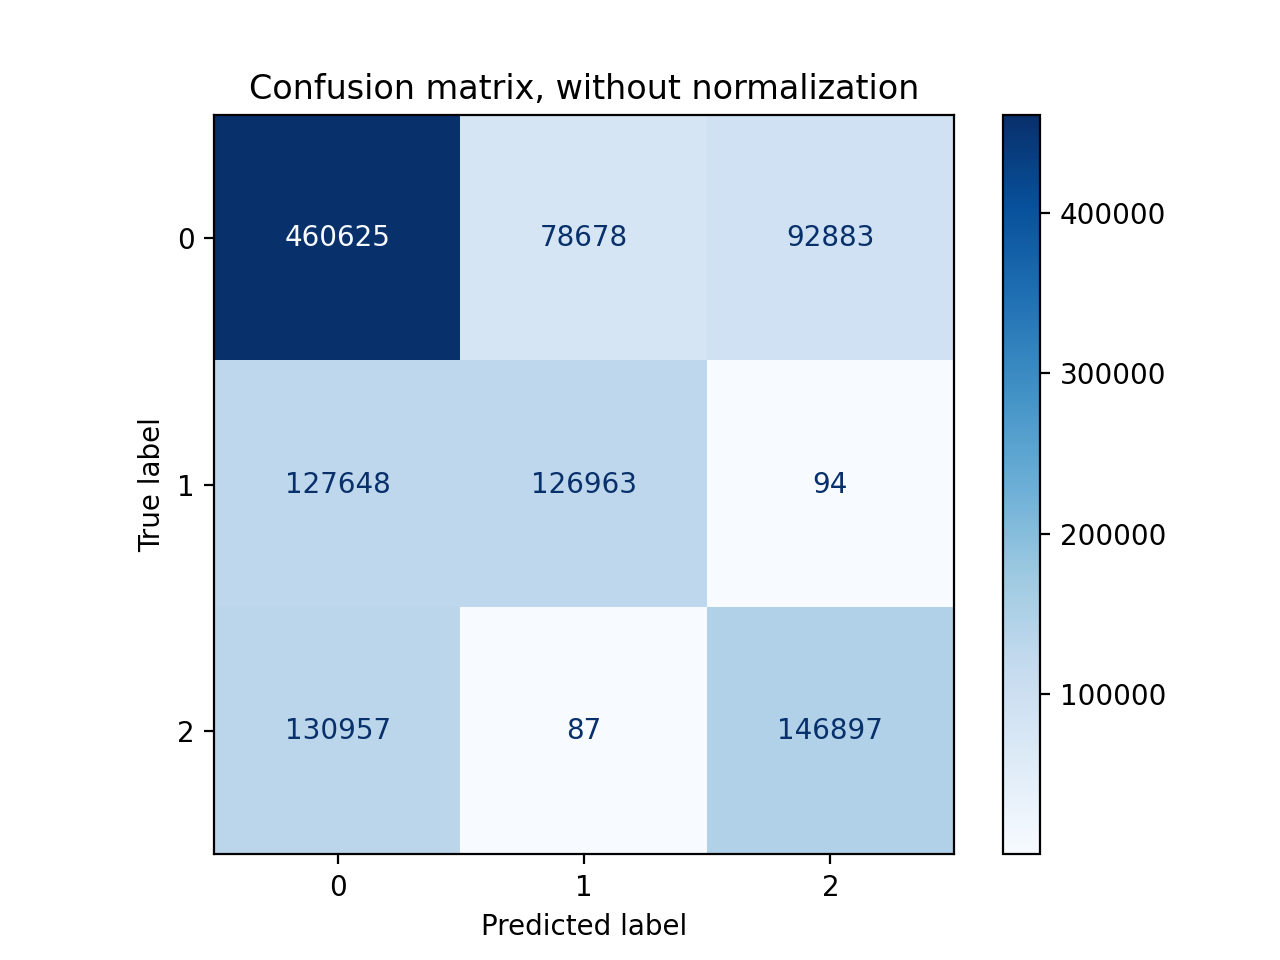

Confusion matrix, without normalization
[[460625  78678  92883]
 [127648 126963     94]
 [130957     87 146897]]


<IPython.core.display.Javascript object>


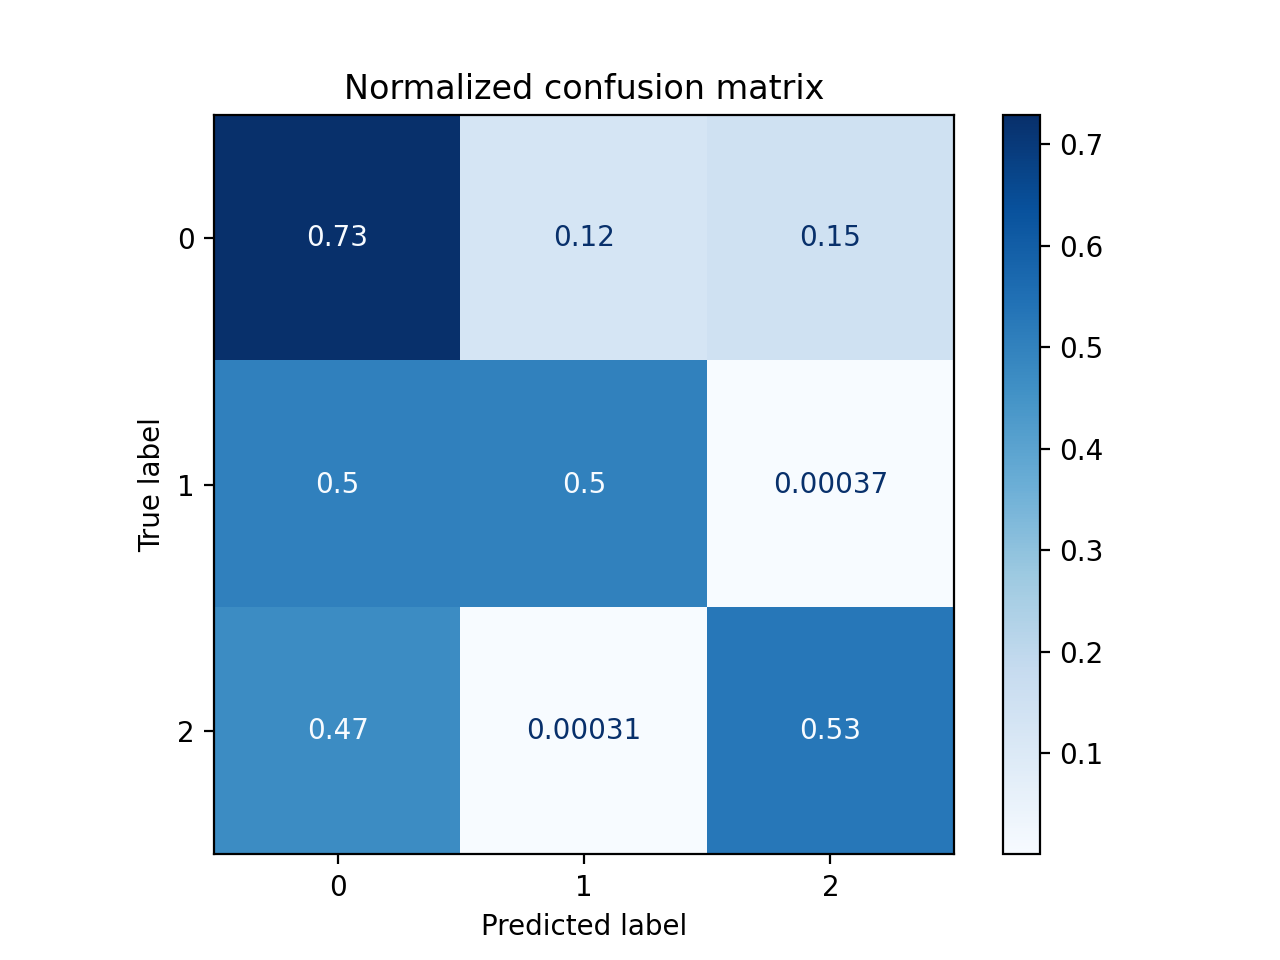

Normalized confusion matrix
[[7.29e-01 1.24e-01 1.47e-01]
 [5.01e-01 4.98e-01 3.69e-04]
 [4.71e-01 3.13e-04 5.29e-01]]


In [56]:
xgboostModel = XGBClassifier(n_estimators=100, max_depth=5)
xgboostModel.fit(X_train_iso, y_train_iso)
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=xgboostModel, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=X_train_iso, train_labels=y_train_iso)

In [57]:
train_data_sc = X_train_iso
train_labels = y_train_iso

<IPython.core.display.Javascript object>


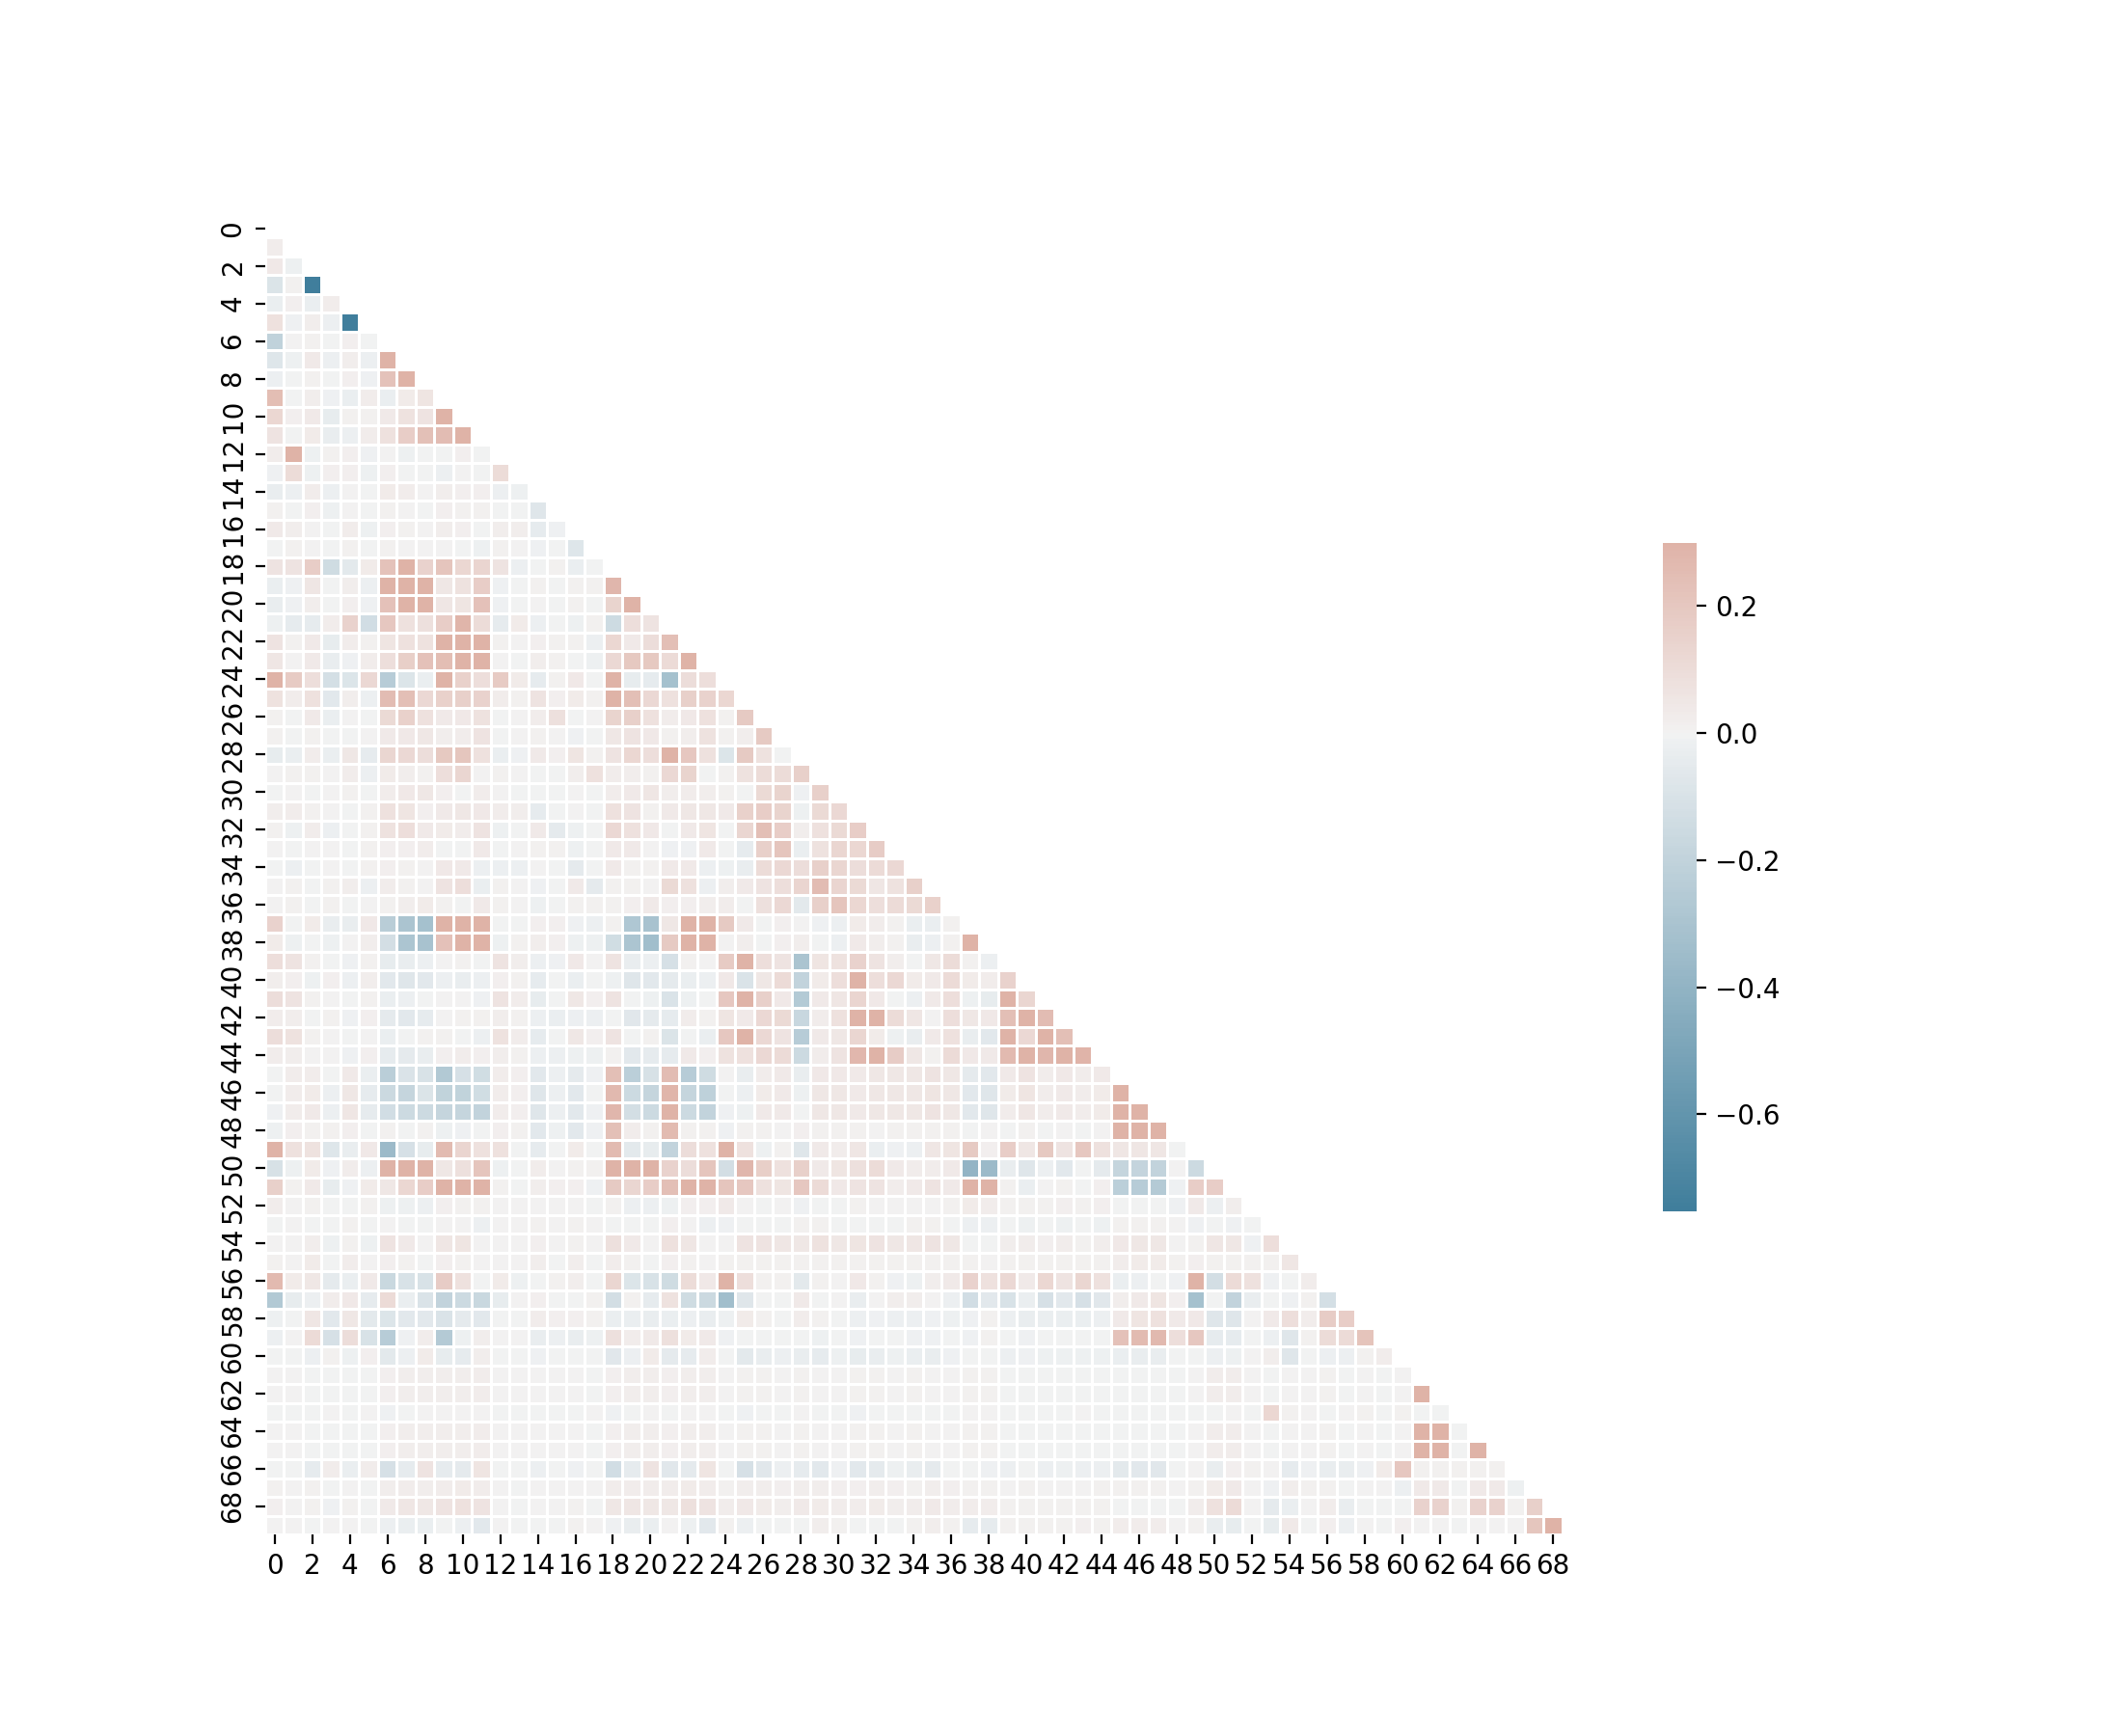

In [58]:
 correlation_map(train_data)

# TSNE Visualization
Here, I use TSNE to visualize the 10-dimension dataset. We can see that class 1 and class 2 can be determined easily but class 0 overlaps class 1 and 2, causing low accracy. This result can correspond to the results of ridge regression.

In [52]:
n_components = 2
params = {
    "n_neighbors": 12,
    "n_components": n_components,
    "eigen_solver": "auto",
    "random_state": 0,
}

manifold_X_train, _, manifold_y_train, _ = train_test_split(X_train_pca10, train_labels, train_size=0.001, shuffle=True, random_state=42)
color_map = ['tab:blue', 'tab:orange', 'tab:green']
S_color = [color_map[y] for y in manifold_y_train]

<IPython.core.display.Javascript object>


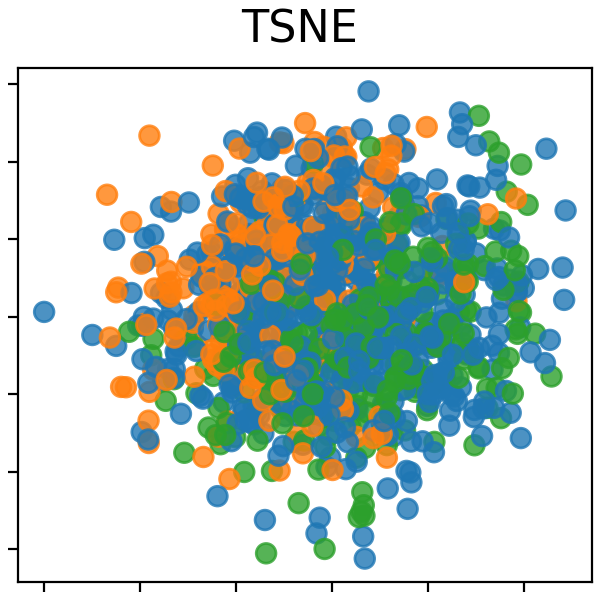

In [53]:
tsne = manifold.TSNE(n_components=n_components,
                    init="random",
                    perplexity=1000,
                    learning_rate="auto",
                    n_iter=300
                    ).fit_transform(manifold_X_train)

# plot_3d(tsne, S_color, "TSNE")
plot_2d(tsne, S_color, "TSNE")

# Random Forest

In [50]:
# clf = RandomForestClassifier(max_depth=None, n_estimators=100, random_state=0, n_jobs=-1)
# clf.fit(train_data_sc, train_labels)

In [51]:
# eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=clf, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=train_data_sc, train_labels=train_labels)

In [54]:
# importances = clf.feature_importances_
# plot_importance(importances=importances, clf=clf)

# Potential Reason 3: Overly Complex Model
## (1) : XGBoost Grid Search with Full-Dimension Dataset
I've conducted a comprehensive grid search for searching best hyperparameters. The best parameter is shown below and the best score is about ?%.

In [70]:
param_stage3 = {
 'learning_rate': [0.01, 0.1, 0.5, 1],
 'gamma':[i/10.0 for i in range(0,5)],
 'max_depth': [5],
 'min_child_weight': [10, 100, 1000, 5000], 
 'subsample': [0.5, 0.8, 1],
 'colsample_bytree': [0.5, 0.8, 1],
 'reg_lambda': [0.01, 0.1, 0.5, 1, 5, 10],
#  'reg_alpha': [],
 'scale_pos_weight': [0.1, 0.5, 1],
}

xgb_gridsearch(params=param_stage3, file_name='gsearch_stage3', X_train=train_data_sc, y_train=train_labels)

/home/student/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [04:04:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/student/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [04:04:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/student/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [04:04:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/student/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [04:04:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/student/anaconda3/envs/py38/lib/python3.8/site-packages/xgboos

In [73]:
with open('gsearch_stage3.pkl', 'rb') as f:
    grid_search = pickle.load(f)
# print(grid_search.cv_results_)
print(grid_search.best_params_)
print(grid_search.best_score_)
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=grid_search.best_estimator_, eval_data=eval_data_sc, eval_labels=eval_labels, train_data=train_data_sc, train_labels=train_labels)

{'mean_fit_time': array([26.8]),
 'std_fit_time': array([0.1]),
 'mean_score_time': array([1.08]),
 'std_score_time': array([0.03]),
 'param_colsample_bytree': masked_array(data=[0.8],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_scale_pos_weight': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.8],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'colsample_bytree': 0.8,
   'gamma': 0,
   'scale_pos_weight': 1,
   'subsample': 0.8}],
 'split0_test_score': array([0.55]),
 'split1_test_score': array([0.55]),
 'split2_test_score': array([0.55]),
 'split3_test_score': array([0.54]),
 'split4_test_score': array([0.55]),
 'mean_test_score': array([0.55]),
 'std_test_score': array([0.]),
 'rank_

{'colsample_bytree': 0.8, 'gamma': 0, 'scale_pos_weight': 1, 'subsample': 0.8}

## (2) : XGBoost Grid Search with 10-Dimension Dataset
I've also conducted grid search on 10-dimensional dataset. However, I found it will get overfitting much more easily. The best testing accuracy is about ?%, which is worse than full-dimensions (70 features).

In [ ]:
param_stage1 = {
 'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
 'gamma':[i/10.0 for i in range(0,5)],
 'max_depth': [3, 5, 7, 10, 15, 20],
 'min_child_weight': [10, 100, 1000], 
 'subsample': [0.8],
 'colsample_bytree': [0.8],
 'scale_pos_weight': [1],
}

param_stage2 = {
 'learning_rate': [0.5],
 'gamma':[0.2],
 'max_depth': [10],
 'min_child_weight': [10, 100, 1000, 5000, 10000], 
 'subsample': [0.5, 0.8, 1],
 'colsample_bytree': [0.5, 0.8, 1],
 'reg_lambda': [0.01, 0.1, 0.5, 1, 10],
#  'reg_alpha': [],
 'scale_pos_weight': [0.5, 1, 2],
}

xgb_gridsearch(params=param_stage2, file_name='gsearch_stage2', X_train=X_train_pca10, y_train=train_labels)

In [ ]:
with open('gsearch_stage2.pkl', 'rb') as f:
    grid_search = pickle.load(f)
# print(grid_search.cv_results_)
print(grid_search.best_params_)
print(grid_search.best_score_)
eval_acc, eval_f1, train_acc, train_f1 = evaluate_model(clf=grid_search.best_estimator_, eval_data=X_test_pca10, eval_labels=eval_labels, train_data=X_train_pca10, train_labels=train_labels)

# Try DNN

In [78]:
batch_size: int = 8192
device: str = 'cuda:1'
n_class: int = 3
n_feature: int = 70
epoch: int = 30
lr: float = 0.01
model_name: str = f"dnn_d{n_feature}_lr{lr}_ep{epoch}"

# X_train_pca10, X_test_pca10 = pca_trans(n_components=10, X_train=train_data_sc, X_test=eval_data_sc)
X_train_tsr = torch.Tensor(train_data_sc).to(device)
# X_train_tsr = torch.Tensor(X_train_pca10).to(device)
y_train_tsr = torch.Tensor(train_labels).long().to(device)
X_test_tsr = torch.Tensor(eval_data_sc).to(device)
# X_test_tsr = torch.Tensor(X_test_pca10).to(device)
y_test_tsr = torch.Tensor(eval_labels).long().to(device)

ds_train = TensorDataset(X_train_tsr, y_train_tsr)
dl_train = DataLoader(ds_train, batch_size=batch_size)
ds_test = TensorDataset(X_test_tsr, y_test_tsr)
dl_test = DataLoader(ds_test, batch_size=batch_size)

print(f"X_train_tsr: {X_train_tsr.shape}")
print(f"y_train_tsr: {y_train_tsr.shape}")

X_train_tsr: torch.Size([1174461, 70])
y_train_tsr: torch.Size([1174461])


In [79]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_feature, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, n_class)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [80]:
for epoch in range(epoch):  # loop over the dataset multiple times

    running_loss = []
#     with tqdm(total=100) as pbar:
    for i, data in tqdm(enumerate(dl_train, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(loss.item())
        
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {sum(running_loss) / len(running_loss):.3f}')
    running_loss = []
#             pbar.update(1)
torch.save(net.state_dict(), model_name)
print('Finished Training')

144it [00:42,  3.42it/s]


[1,   144] loss: 0.696


144it [00:38,  3.69it/s]


[5,   144] loss: 0.666


144it [00:42,  3.42it/s]


[6,   144] loss: 0.665


144it [00:40,  3.55it/s]


[7,   144] loss: 0.665


144it [00:48,  2.99it/s]


[8,   144] loss: 0.664


144it [00:45,  3.14it/s]


[9,   144] loss: 0.664


144it [00:44,  3.22it/s]


[10,   144] loss: 0.663


144it [00:40,  3.59it/s]


[11,   144] loss: 0.663


144it [00:47,  3.06it/s]


[12,   144] loss: 0.662


144it [00:42,  3.36it/s]


[13,   144] loss: 0.666


144it [00:44,  3.20it/s]


[14,   144] loss: 0.662


144it [00:39,  3.67it/s]


[15,   144] loss: 0.661


144it [00:43,  3.29it/s]


[16,   144] loss: 0.661


144it [00:40,  3.60it/s]


[17,   144] loss: 0.661


144it [00:39,  3.60it/s]


[18,   144] loss: 0.660


144it [00:42,  3.36it/s]


[19,   144] loss: 0.660


144it [00:41,  3.45it/s]


[20,   144] loss: 0.660


144it [00:44,  3.26it/s]


[21,   144] loss: 0.660


144it [00:42,  3.40it/s]


[22,   144] loss: 0.659


144it [00:39,  3.63it/s]


[23,   144] loss: 0.659


144it [00:42,  3.43it/s]


[24,   144] loss: 0.659


144it [00:39,  3.65it/s]


[25,   144] loss: 0.662


144it [00:38,  3.74it/s]


[26,   144] loss: 0.658


144it [00:41,  3.49it/s]


[27,   144] loss: 0.658


144it [00:41,  3.49it/s]


[28,   144] loss: 0.658


144it [00:43,  3.31it/s]


[29,   144] loss: 0.657


144it [00:42,  3.37it/s]

[30,   144] loss: 0.657
Finished Training


In [81]:
def dnn_eval(model, dl, device):
    model.eval()
    model = model.to(device)
    preds_list = []
    y_list = []
    for i, data in enumerate(dl, 0):
        inputs, labels = data
        outputs = model(inputs)
        preds_list.append(outputs)    
        y_list.append(labels)
    preds = torch.cat(preds_list, axis=0)
    ys = torch.cat(y_list, axis=0)
    
    f1 = multiclass_f1_score(preds, ys, num_classes=n_class, average='weighted')
    acc = multiclass_accuracy(preds, ys, num_classes=n_class)
    precision = multiclass_precision(preds, ys, num_classes=n_class, average='weighted')
    recall = multiclass_recall(preds, ys, num_classes=n_class, average='weighted')
#     print(f"Acc: {acc:.3f}, F1 Score: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")
    return preds, acc, f1, precision, recall

In [ ]:
model = Net()
model.load_state_dict(torch.load(model_name))
preds, acc, f1, precision, recall = dnn_eval(model=model, dl=dl_test, device=device)
print(f"Test Acc: {acc:.3f}, F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

preds, acc, f1, precision, recall = dnn_eval(model=model, dl=dl_train, device=device)
print(f"Train Acc: {acc:.3f}, F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

Test Acc: 0.595, F1: 0.591, Precision: 0.592, Recall: 0.595
